# I. Import Libraries and data

In [4]:
%pip install gdown
%pip install cartopy
%pip install seaborn
%pip install libpysal
%pip install esda
%pip install --upgrade gdown

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [5]:
# A few imports to make everything work
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import random
import geopandas as gpd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from itertools import cycle
from ipywidgets import widgets, interactive
from datetime import datetime
import warnings
import seaborn as sns
import sys
import seaborn as sns
from shapely.geometry import Point
import matplotlib.animation as animation
from IPython.display import HTML
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.stats import invgamma
import copy
from sklearn.preprocessing import StandardScaler

# Getting rid of a few warnings (can be toggled off)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Install cmdstanpy module
# !pip install cmdstanpy

# Install arviz module (With version 2.33.1 you will need a special version of arviz)
# !pip install git+https://github.com/OriolAbril/arviz.git@ci

# Install cmdstan -- Just for the first time!
# from cmdstanpy import install_cmdstan
# install_cmdstan()

# Import modules for stan
# import arviz as az

# Import functions for stan
# from cmdstanpy import CmdStanModel

In [6]:
file_id = '1EQjwC00wD1-tjtwS8XgS__dGYvpovg51'
gdown_link = f'https://drive.google.com/uc?id={file_id}'

zip_path = 'content/dati_ozono.zip'
gdown.download(gdown_link, zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1EQjwC00wD1-tjtwS8XgS__dGYvpovg51
From (redirected): https://drive.google.com/uc?id=1EQjwC00wD1-tjtwS8XgS__dGYvpovg51&confirm=t&uuid=74a738a0-8036-414c-a38e-84ca53ae3230
To: c:\Users\nb23N\Downloads\content\dati_ozono.zip
100%|██████████| 27.0M/27.0M [00:15<00:00, 1.74MB/s]


'content/dati_ozono.zip'

In [7]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [8]:
csv_files = [file for file in os.listdir('/content/dati_ozono') if file.endswith('.csv')]
dataframes = {file: pd.read_csv(os.path.join('/content/dati_ozono', file)) for file in csv_files}

print(csv_files)

['datasetO3.csv', 'stazioni_O3.csv']


In [9]:
for filename, df in dataframes.items():
    print(f"Contents of {filename}:")
    print(df.head())

Contents of datasetO3.csv:
   idSensore                    Data  Valore Stato  idOperatore
0       5707  01/01/2010 01:00:00 AM     2.9    VA            1
1       5707  01/01/2010 02:00:00 AM     2.9    VA            1
2       5707  01/01/2010 03:00:00 AM     2.9    VA            1
3       5707  01/01/2010 04:00:00 AM     2.9    VA            1
4       5707  01/01/2010 05:00:00 AM     2.9    VA            1
Contents of stazioni_O3.csv:
   Unnamed: 0  IdSensore NomeTipoSensore UnitaMisura  Idstazione  \
0           7       5749           Ozono       µg/m³         554   
1          11       5735           Ozono       µg/m³         576   
2          21      10324           Ozono       µg/m³         707   
3          25      10112           Ozono       µg/m³         698   
4          41       5738           Ozono       µg/m³         607   

                  NomeStazione  Quota Provincia           Comune Storico  \
0          Saronno v.Santuario  212.0        VA          Saronno       N   

In [10]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# II. Initial Merges of the data

In [11]:
# Reading of the first DB
df1 = dataframes['datasetO3.csv']
df1 = df1.loc[:,['idSensore','Valore','Data']]

sensors = df1['idSensore'].unique().tolist()
print(f'Whole dataset contains {df1.shape[0]} data from {len(sensors)} sensors')

Whole dataset contains 5552198 data from 51 sensors


In [12]:
# Create the actual dataframe for datasetO3
df_data = pd.DataFrame(columns=['idSensore','Valore','Data'])

# Turn hourly data into week averages
for sensor in sensors:
  df_temp = df1[df1['idSensore'] == sensor].copy()
  df_temp['Data'] = pd.to_datetime(df_temp['Data'], format='%m/%d/%Y %I:%M:%S %p')
  # Insert in the actual dataset the shrinked one
  df_data = pd.concat([df_data, df_temp.resample('W', on='Data').mean(numeric_only=True)])

# Fixing indexes
df_data.Data = df_data.index
df_data.index = range(df_data.shape[0])

In [13]:
#Reading of the second DB
df_stat = dataframes['stazioni_O3.csv']

# Join both DBs into the final one: 'df'
df = df_data.join(df_stat.set_index('IdSensore'), on='idSensore')
df = df.dropna(subset=['idSensore'])
df['Data'] = pd.to_datetime(df['Data'])

# [Corrected from before] now df has only the data collected in 2010-2017 timespan, independently on when the station started/ended to collect them
startm = '2010-01-01'
endm = '2017-12-31'
df = df.loc[(df['Data'] >= startm) & (df['Data'] <= endm)]
df = df.reset_index()

# III. Useful functions

In [ ]:
# Some useful lists to simplify stuff
cities = df.Comune.unique().tolist()
sensors = list(map(int, df.idSensore.unique().tolist()))
years = list(range(2010,2018,1))
provinces = df.Provincia.unique().tolist()

In [ ]:
def gen_filtered_df(df=df, cities=None, ids=None, timespan=None, provs=None):
  """
   This function generates a new dataframe based on filters given as (optional) parameters
   Args:
   cities (list/None): [Comune1, Comune2, ...]
   ids (list/None): [idSensore1, idSensore2, ...]
   timespan (list/None): [2010, ...]
   provs (list/None): [Provincia1, ....]
   Returns: an instance of the filtered dataframe
  """
  df_filtered = df.copy()
  if cities is not None:
    df_filtered = df_filtered[df_filtered['Comune'].isin(cities)]
  if ids is not None:
    df_filtered = df_filtered[df_filtered['idSensore'].isin(ids)]
  if timespan is not None:
    df_filtered = df_filtered[df_filtered['Data'].dt.year.isin(timespan)]
  if provs is not None:
    df_filtered = df_filtered[df_filtered['Provincia'].isin(provs)]
  return df_filtered

In [ ]:
def randgenCY_df(df=df, cities=cities, years=years):
    """
    This function generates a dataframe out of a few random cities and a random timespan
    Args: (do not change pls)
    cities, years (list): lists of all unique cities and years
    Returns: randomly generated dataframe
    """
    # the '6' can be changed to extract more cities in the dataframe (if you do it, please change the code to extract a feasible amount of years)
    ext_num = random.sample(range(1, 6), 2)
    ext_cities = random.sample(cities, ext_num[0])
    ext_year_start = random.randint(0, len(years) - ext_num[1] - 1)
    ext_years = list(years[ext_year_start: ext_year_start + ext_num[1]])
    print(f'Generating a dataframe based on data from {ext_cities} during years {ext_years}')

    return gen_filtered_df(df, cities=ext_cities, timespan=ext_years)

In [ ]:
def randgenSY_df(df=df, sensors=sensors, years=years):
    """
    This function generates a dataframe out of a few random sensors and a random timespan
    Args: (do not change pls)
    sensors, years (list): lists of all unique sensors(ids) and years
    Returns: randomly generated dataframe
    """
    # the '6' can be changed to extract more sensors in the dataframe (if you do it, please change the code to extract a feasible amount of years)
    ext_num = random.sample(range(1, 6), 2)
    ext_sensors = random.sample(sensors, ext_num[0])
    ext_year_start = random.randint(0, len(years) - ext_num[1] - 1)
    ext_years = list(years[ext_year_start: ext_year_start + ext_num[1]])

    print(f'Generating a dataframe based on data from sensors: {ext_sensors} during years {ext_years}')

    return gen_filtered_df(df, ids=ext_sensors, timespan=ext_years)

In [ ]:
def plot_stations(df=df, provinces=provinces):
  """
  This function plots the approximate location of stations measuring ozone across Lombardy
  Args: (do not change df)
  provinces (list): lists of all unique provinces [default], list of filtered provinces to plot
  Returns: map of northern part of Italy
  """
  # Obtain Italy border (couldn't find the regional-specific one, sorry)
  italy = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  italy = italy[italy['name'] == 'Italy']

  # Use this projection to base the plot on coordinates
  fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

  # Draw actual borders
  italy.boundary.plot(ax=ax, color='black', linewidth=1.5)

  colors = cycle(plt.cm.tab10.colors)
  # For each province, choose a color and plot locations of stations in that province
  for p in provinces:
    df_provs = df[df['Provincia'] == p]
    cur_col = next(colors)
    ax.scatter(df_provs['lng'], df_provs['lat'], label=p, color=cur_col, s=7.5)

  # Adjust plot
  ax.set_ylim(44,47)
  ax.set_xlim(8,12)
  ax.set_title('Ozone stations in Lombardy')
  ax.legend()

  # Visualizza la mappa
  plt.show()

In [ ]:
def plot_values(df_list):
  """
  This function plots, for each dataframe in the list, the distribution of values over time
  [IMPORTANT]: Don't submit lists too long or dataframes too big, it doesn't work
  Args:
  df_list (list): list of dataframes with max length of 15
  Returns: subplots of each dataframe's values over time
  """
  # Just checking if you do something like "plot me the whole dataset"
  if len(df_list) > 15:
    print('This function should receive a smaller list of dataframes. Please reduce the size of df_list parameter')
    return

  # Plotting one for each row to keep it understandable
  fig, axs = plt.subplots(len(df_list), 1, figsize=(15, 35))

  for i, df_temp in enumerate(df_list):
    # Filter relevant columns, remove data if sensor is unknown (i think there's enough data to simply drop those lines and not try to infer NaN values)
    df_plot = df_temp[['Comune', 'Data', 'Valore', 'idSensore']]
    df_plot = df_plot.dropna(subset=['idSensore'], axis=0)

    df_plot = df_plot.sort_values(by='Data')
    colors = cycle(plt.cm.tab10.colors)

    for sensor, group in df_plot.groupby('idSensore'):
        cur_col = next(colors)
        # Finding nan values and plot markers in corrispondence of the missing point
        nan_indices = group['Valore'].isna()
        axs[i].plot(group['Data'][nan_indices], [0] * nan_indices.sum(), 'o', markersize=5, color=cur_col)

        axs[i].plot(group['Data'], group['Valore'], label=f'{group["Comune"].iloc[0]}', color=cur_col)

    axs[i].axhline(y=80, color='black', linestyle='--', alpha=0.1, label='Security Threshold')

    axs[i].legend()

  plt.xlabel('Date')
  plt.ylabel('Value')

  plt.show()

In [ ]:
def plot_rollingavg(df):
    """
    This function plots the moving average for each sensor in the dataframe given as parameter
    Args:
    - df: dataframe containing measurements (better if it is a provincial dataset rather than the full one)
    """

    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by=['idSensore', 'Data'], inplace=True)
    # Just some garbage variables since idk how to make the title looking nice
    provs_dict = {'MI': 'Milano','MB': 'Monza e Brianza','CO': 'Como','LC': 'Lecco','LO': 'Lodi','SO': 'Sondrio','VA': 'Varese','CR': 'Cremona','PV': 'Pavia','BS': 'Brescia','MN': 'Mantova','BG': 'Bergamo'}
    provs_here = df.Provincia.unique()
    provs_title = [provs_dict[p] for p in provs_here]

    window_size = 3 * 52 # Eventually change this to 2*52
    # Creating a new column containing the rolling average for 3 years (52 weeks per year)
    df['RollingAvg'] = df.groupby('idSensore')['Valore'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

    plt.figure(figsize=(12, 8))

    colors = cycle(plt.cm.tab10.colors)

    for i, (sensor_id, group) in enumerate(df.groupby('idSensore')):
        color = next(colors)
        # I'm not 100% sure about this guys, if i include data before the start of 2013 i shouldn't have enough data to compute the mean
        # but at the same time, some sensors stopped working before 2017, making it kinda impossible to have a decent plot
        group = group[group['Data'] >= '2013-01-01'] # Eventually change this to 2012
        plt.plot(group['Data'], group['RollingAvg'], label=f'{group.Comune.iloc[0]}', color=color)

    plt.xlabel('Years')
    plt.ylabel('Rolling Average')
    plt.title('3 year Rolling average for all sensors in {}'.format(', '.join(provs_title))) # Eventually change this to 2
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [ ]:
def plot_heatmap(df=df, selected_provinces=provinces, selected_month=1, selected_year=2010):
    """
    This function plots a "dynamic" map to understand better the evolution of gathered data.
    Args: [IMPORTANT]
    df (pd.DataFrame): dataframe containing high number of rows (default = whole df)
    provinces (list): list of provinces you're interested in exploring data (default = all provinces)
    selected_month, selected_year: see next block for more informations
    Returns: an approximate map with the location and value of each measurement row in a given province and time istant (monthly average), a color scale is
    also shown for better understanding
    """
    df_selected_month = df.loc[(df['Data'].dt.month == selected_month) & (df['Data'].dt.year == selected_year) & (df['Provincia'].isin(selected_provinces))]

    italy = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    italy = italy[italy['name'] == 'Italy']
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
    italy.boundary.plot(ax=ax, color='black', linewidth=1.5)

    # Plot points in map
    sc = ax.scatter(
        df_selected_month['lng'],
        df_selected_month['lat'],
        c=df_selected_month['Valore'],
        cmap='viridis',
        s=150,  # points size
        marker='o',
        transform=ccrs.PlateCarree(),
        edgecolors='none',
        vmin=0,
        vmax=130,
        alpha=0.8
    )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Monthly mean value', rotation=270, labelpad=15)

    ax.set_ylim(44, 47)
    ax.set_xlim(8, 12)
    ax.set_title(f'Ozone stations in Lombardy - {selected_month}/{selected_year}')

    plt.show()

# IV. Data Analysis

## IV.1. Box plot of the daily average ozone concentration level over years

In [ ]:
# Convert the 'Data' column to datetime
df['Data'] = pd.to_datetime(df['Data'])

# Group by date and calculate the sum for each date
grouped_data = df.groupby(df["Data"]).mean()

df_copy = df.copy()

# Group by date and calculate the sum for each date
grouped_data = df.groupby(df.index).mean()

# Convert the 'Date' column to a datetime object
df_copy['Data'] = pd.to_datetime(df_copy['Data'])

# Extract the year and create a new 'Year' column
df_copy['Year'] = df_copy['Data'].dt.year

grouped_data['Year'] = df_copy['Data'].dt.year

grouped_data

index  idSensore     Valore  Unnamed: 0  Idstazione  Quota  \
0          0.0     5707.0  17.546479       305.0       551.0  182.0   
1          1.0     5707.0   6.390476       305.0       551.0  182.0   
2          2.0     5707.0   4.245752       305.0       551.0  182.0   
3          3.0     5707.0   2.885246       305.0       551.0  182.0   
4          4.0     5707.0  18.532824       305.0       551.0  182.0   
...        ...        ...        ...         ...         ...    ...   
20209  33240.0    30165.0   6.484524       362.0       669.0   70.0   
20210  33241.0    30165.0   5.957143       362.0       669.0   70.0   
20211  33242.0    30165.0   1.448000       362.0       669.0   70.0   
20212  33243.0    30165.0   3.500794       362.0       669.0   70.0   
20213  33244.0    30165.0   9.197333       362.0       669.0   70.0   

        Utm_Nord   UTM_Est        lat        lng  Year  
0      5043898.0  488082.0  45.548517   8.847322  2010  
1      5043898.0  488082.0  45.548517   8.847322  2010  
2      5043898.0  488082.0  45.548517   8.847322  2010  
3      5043898.0  488082.0  45.548517   8.847322  2010  
4      5043898.0  488082.0  45.548517   8.847322  2010  
...          ...       ...        ...        ...   ...  
20209  5040636.0  593101.0  45.513039  10.191942  2017  
20210  5040636.0  593101.0  45.513039  10.191942  2017  
20211  5040636.0  593101.0  45.513039  10.191942  2017  
20212  5040636.0  593101.0  45.513039  10.191942  2017  
20213  5040636.0  593101.0  45.513039  10.191942  2017  

[20214 rows x 11 columns]

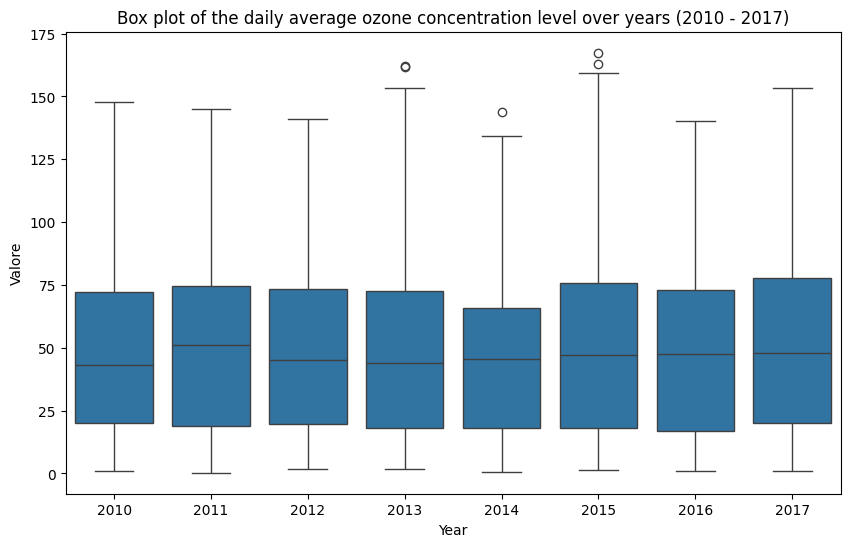

Outlires:  [161.95178571 161.53809524 158.42738095 163.01796407 167.37857143
 157.27440476 159.4077381 ]


In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Year', y='Valore', data=grouped_data)
plt.title('Box plot of the daily average ozone concentration level over years (2010 - 2017)')
plt.show()

# Identify and get the values of outliers
q1 = df_copy['Valore'].quantile(0.25)
q3 = df_copy['Valore'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_copy[(df_copy['Valore'] < lower_bound) | (df_copy['Valore'] > upper_bound)]

# Display the outliers
print("Outlires: ", np.array(outliers.Valore))

## IV.2. Box-Cox data transformation

In [ ]:
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Specify the column from which you want to remove NaN values
column_to_clean = 'Valore'

# Create a new variable to store the cleaned column
cleaned_column = df[column_to_clean].dropna().copy()

# Perform the Box-Cox transformation
transformed_data, lambda_value = boxcox(cleaned_column)

# Print the estimated lambda value
print(f"Optimal lambda value: {lambda_value}")

#insert the transformed data in a new "BoxCoxValore" column in the dataset

# Get the indices of NaN values in the specified column
nan_indices = df.loc[df["Valore"].isna()].index
new_values = transformed_data

#insert Nan values in the cleaned_column
for index in nan_indices:
  new_values = np.insert(new_values, index, np.nan)

df["BoxCoxValore"] = new_values

Optimal lambda value: 0.4986916389396704


kurtosis: -0.8088626670216019
skewness: 0.35050468800978857


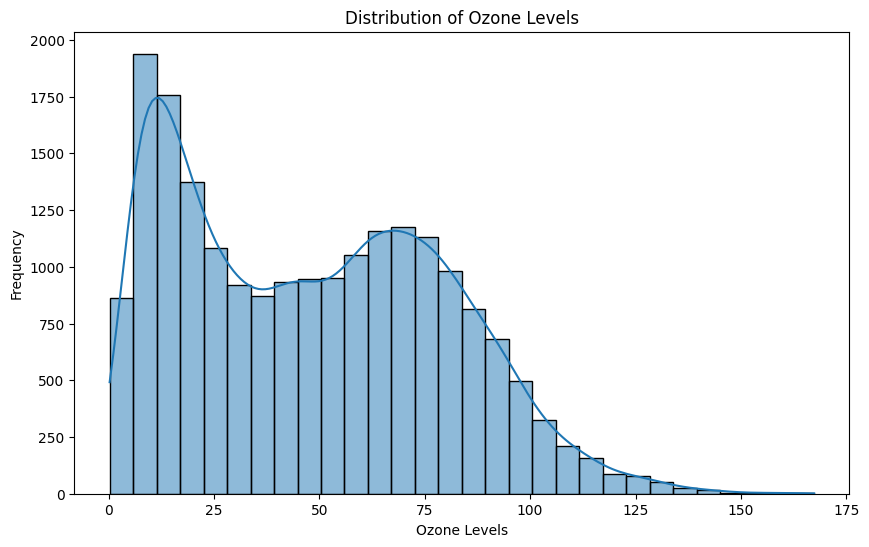

kurtosis: -1.0682056852257298
skewness: -0.1782807252943061


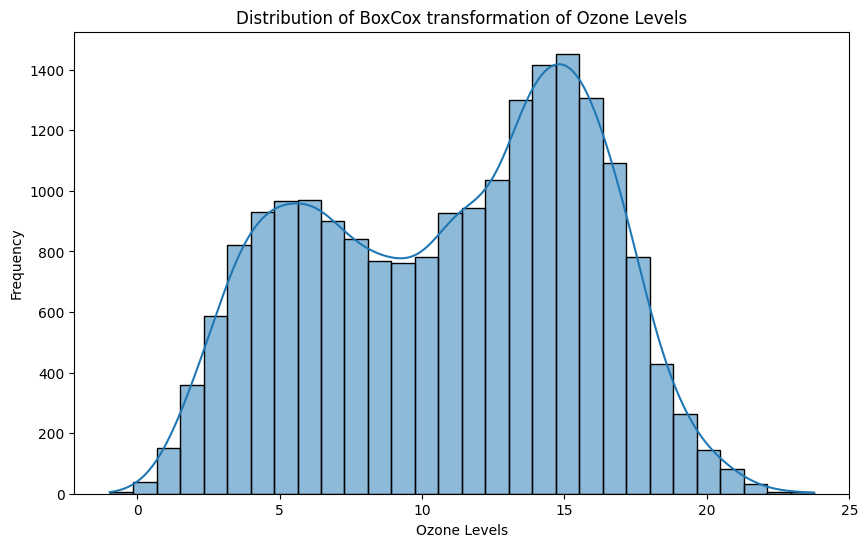

In [ ]:
import seaborn as sns

# Calculate the skewness and kurtosis of 'Valore'
skewness = df['Valore'].skew()
kurtosis = df['Valore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'Valore'
plt.figure(figsize=(10, 6))
sns.histplot(df['Valore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Ozone Levels')
plt.show()

# Calculate the skewness and kurtosis of 'BoxCoxValore'
skewness = df['BoxCoxValore'].skew()
kurtosis = df['BoxCoxValore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'BoxCoxValore'
plt.figure(figsize=(10, 6))
sns.histplot(df['BoxCoxValore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of BoxCox transformation of Ozone Levels')
plt.show()

## VI.3. Basic stats

kurtosis: -0.8088626670216019
skewness: 0.35050468800978857


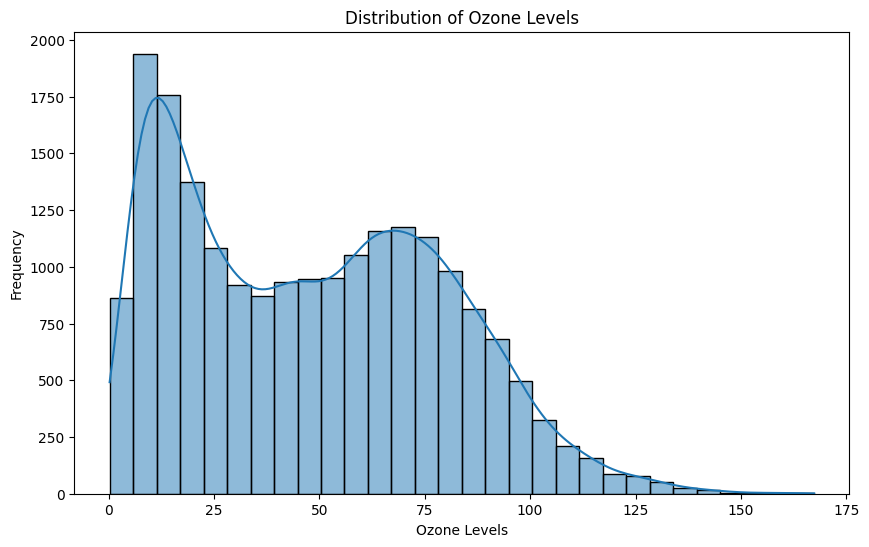

In [ ]:
# Calculate the skewness and kurtosis of 'Valore'
skewness = df['Valore'].skew()
kurtosis = df['Valore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'Valore'
plt.figure(figsize=(10, 6))
sns.histplot(df['Valore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Ozone Levels')
plt.show()

In [ ]:
# Google Drive shareable link
url = 'https://drive.google.com/uc?id=1gIdk0wxfjWT61EPZ5kxtO_zvCaU-3MVL'

output = 'lombardy.geojson' # Output filename

gdown.download(url, output, quiet=False) # Download the file from the URL

Downloading...
From: https://drive.google.com/uc?id=1gIdk0wxfjWT61EPZ5kxtO_zvCaU-3MVL
To: /content/lombardy.geojson




  0%|          | 0.00/4.47M [00:00<?, ?B/s]



100%|██████████| 4.47M/4.47M [00:00<00:00, 26.9MB/s]


'lombardy.geojson'

In [ ]:
# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file('lombardy.geojson')

In [ ]:
# Convert coordinate strings to Point objects
def parse_coordinates(coord_str):
    lat, lng = map(float, coord_str.strip('()').split(', '))
    return Point(lng, lat)

df['geometry'] = df['location'].apply(parse_coordinates)

# Convert df to a GeoDataFrame and set the CRS to EPSG:4326 (for latitude and longitude)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# If your Lombardy GeoDataFrame (gdf) is not in the same CRS, change it to match
gdf = gdf.to_crs("EPSG:4326")

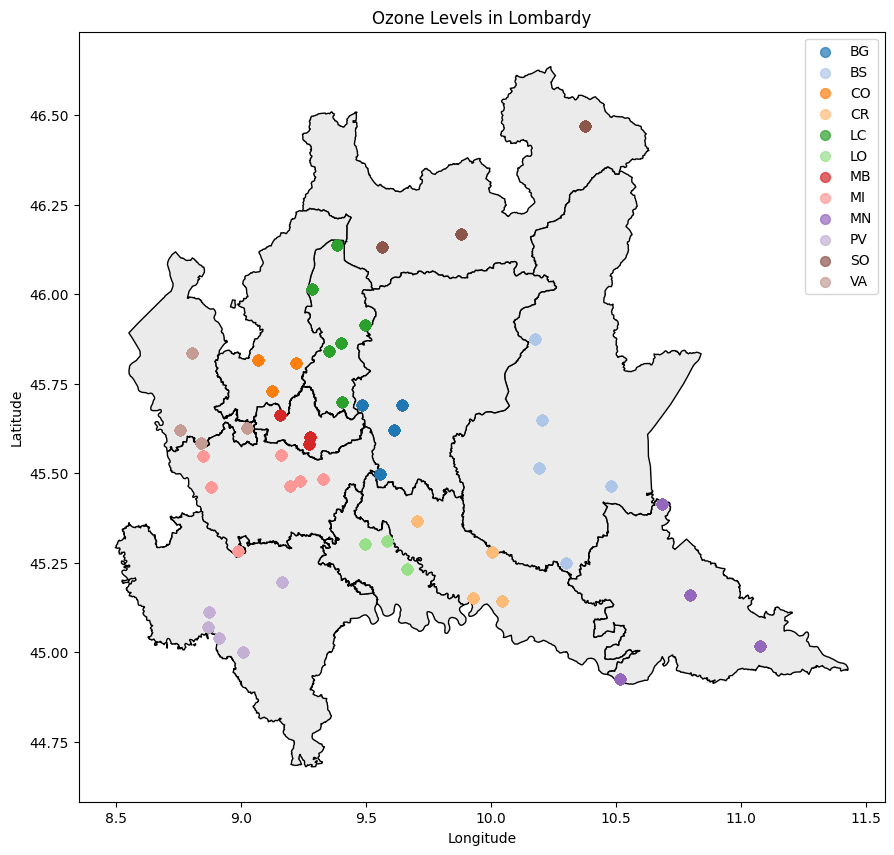

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Lombardy region map
gdf.plot(ax=ax, color='#ebebeb', edgecolor='black')

colors = cycle(plt.cm.tab20.colors)
for province, group in gdf_points.groupby('Provincia'):
    color = next(colors)
    group.plot(ax=ax, markersize=50, alpha=0.7, color=color, marker='o', label=province)

# Adding titles and labels
plt.title('Ozone Levels in Lombardy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

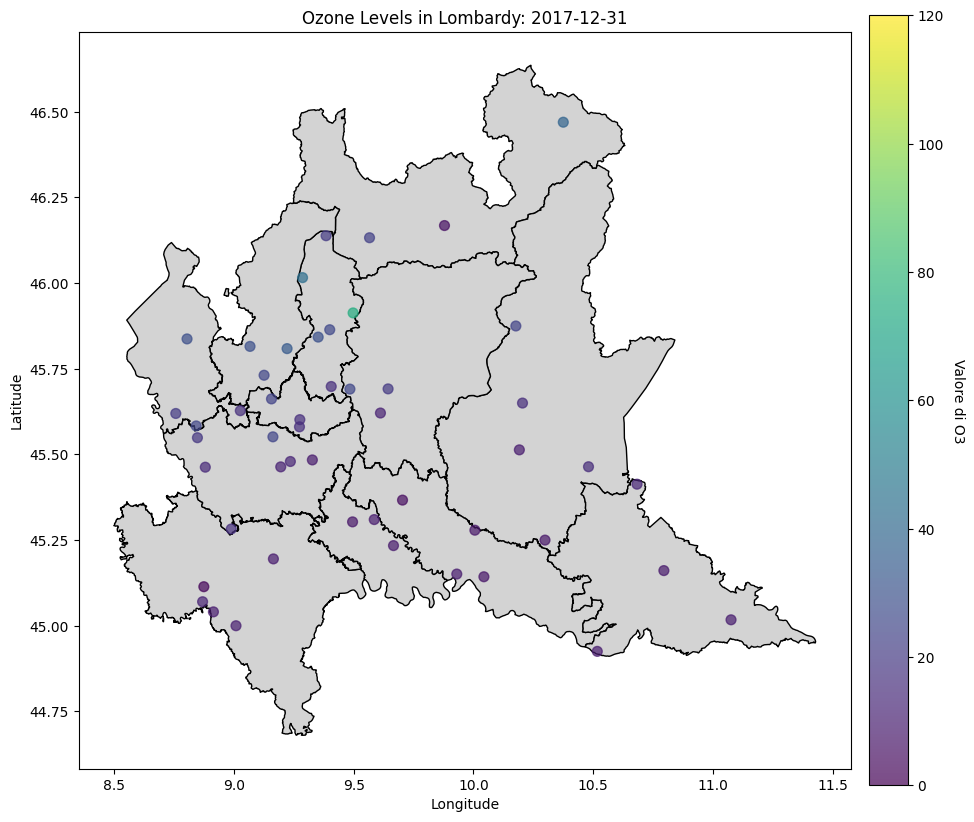

In [ ]:
df['Data'] = pd.to_datetime(df['Data'])
df.sort_values('Data', inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ozone Levels in Lombardy Over Time')

scatter = ax.scatter([], [], s=50, c=[], cmap='viridis', alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Valore di O3', rotation=270, labelpad=15)

def update(frame):
    current_date = df['Data'].unique()[frame]
    current_date_formatted = pd.to_datetime(str(current_date)).strftime('%Y-%m-%d') # Convert numpy.datetime64 to standard datetime
    df_current = df[df['Data'] == current_date]
    scatter.set_clim(0, 120)
    scatter.set_offsets(df_current[['lng', 'lat']])
    scatter.set_array(df_current['Valore'])
    ax.set_title(f'Ozone Levels in Lombardy: {current_date_formatted}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(df['Data'].unique()), interval=200, blit=True)

# Display in Jupyter Notebook
HTML(ani.to_html5_video())

In [ ]:

missing_data_df = df.isnull().sum()
print("Missing:\n", missing_data_df)

Missing:
 index                  0
idSensore              0
Valore               112
Data                   0
Unnamed: 0             0
NomeTipoSensore        0
UnitaMisura            0
Idstazione             0
NomeStazione           0
Quota                418
Provincia              0
Comune                 0
Storico                0
DataStart              0
DataStop           19796
Utm_Nord               0
UTM_Est                0
lat                    0
lng                    0
location               0
BoxCoxValore         112
geometry               0
dtype: int64


In [ ]:
df_cleaned = df.dropna(subset=['Valore'])
missing_data_df = df_cleaned.isnull().sum()
print("Missing:\n", missing_data_df)

Missing:
 index                  0
idSensore              0
Valore                 0
Data                   0
Unnamed: 0             0
NomeTipoSensore        0
UnitaMisura            0
Idstazione             0
NomeStazione           0
Quota                415
Provincia              0
Comune                 0
Storico                0
DataStart              0
DataStop           19686
Utm_Nord               0
UTM_Est                0
lat                    0
lng                    0
location               0
BoxCoxValore           0
geometry               0
dtype: int64


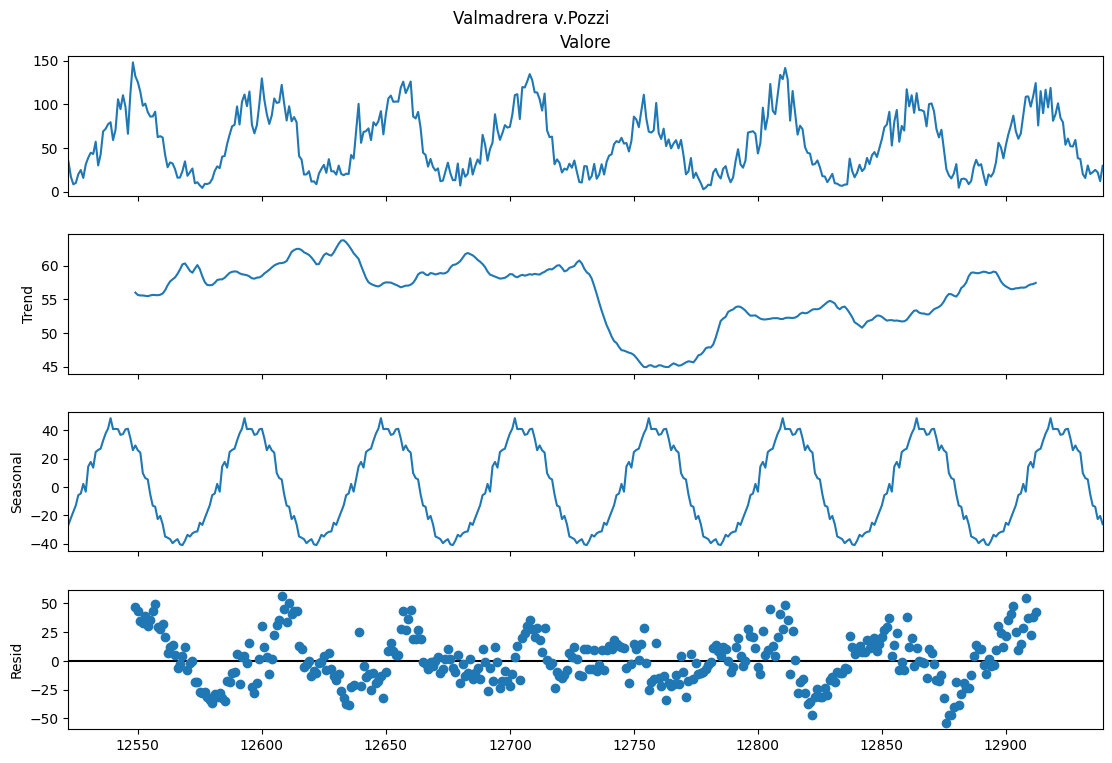

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

seed = 42

# Assuming df_cleaned is your cleaned DataFrame
# Pick one random 'NomeStazione' with the seed set
random_station = df_cleaned['NomeStazione'].sample(n=1, random_state=seed).iloc[0]

# Filter the DataFrame by the selected station
filtered_df = df_cleaned[df_cleaned['NomeStazione'] == random_station]

# Seasonal Decompose
result = seasonal_decompose(filtered_df['Valore'], model='additive', period=54)
fig = result.plot()
fig.set_size_inches(12, 8)

# Add the station name to the title
plt.suptitle(f"{random_station}")

plt.show()


#1st Plot (Valore): original data. It shows seasonality, with regular fluctuations suggesting higher ozone concentrations that could be related to warmer months and lower concentrations during colder periods.

#2nd Plot (Trend): gets rid of seasonal fluctuations and shows the longterm trend. slight undulating trend but no a clear long-term increase or decrease.

#3rd Plot (Seasonal): This shows the seasonal pattern within the data, repeating over a specified period (I think ? annually). The peaks and troughs are repeated systematically.

#4th Plot (Residual): shows the noise in the data after the trend and seasonal components were removed. The plot shows some randomness, but there seem to be some extreme values that we should interestigate.

In [ ]:
def plot_decomposition(df):
    """
    This function prints the various plots of "Value", "Trend", "Seasonality" and "Residuals" for each station of the dataframe
    Args:
    - df: Dataframe (try to give a provincial one, or else remove the legend due to the 51 stations)
    """
    df['Data'] = pd.to_datetime(df['Data'])
    stations = df['NomeStazione'].unique()

    colors = cycle(plt.cm.tab10.colors)
    # Create a subplot for each considered stat
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    for st in stations:
       colore = next(colors)
       df_st = df[df['NomeStazione'] == st]
       result = seasonal_decompose(df_st['Valore'], model='additive', period=52)

       # Add plots for each stat
       axs[0].plot(df_st['Data'], df_st['Valore'], label=f"{st}", color=colore)
       axs[1].plot(df_st['Data'], result.trend, label=f"{st}", color=colore)
       axs[2].plot(df_st['Data'], result.seasonal, label=f"{st}", color=colore)
       axs[3].plot(df_st['Data'], result.resid, label=f"{st}", color=colore)

    axs[0].set_title("Value")
    axs[1].set_title("Trend")
    axs[2].set_title("Seasonality")
    axs[3].set_title("Residuals")

    axs[3].set_xlabel("Year")

    for ax in axs:
        ax.legend(title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

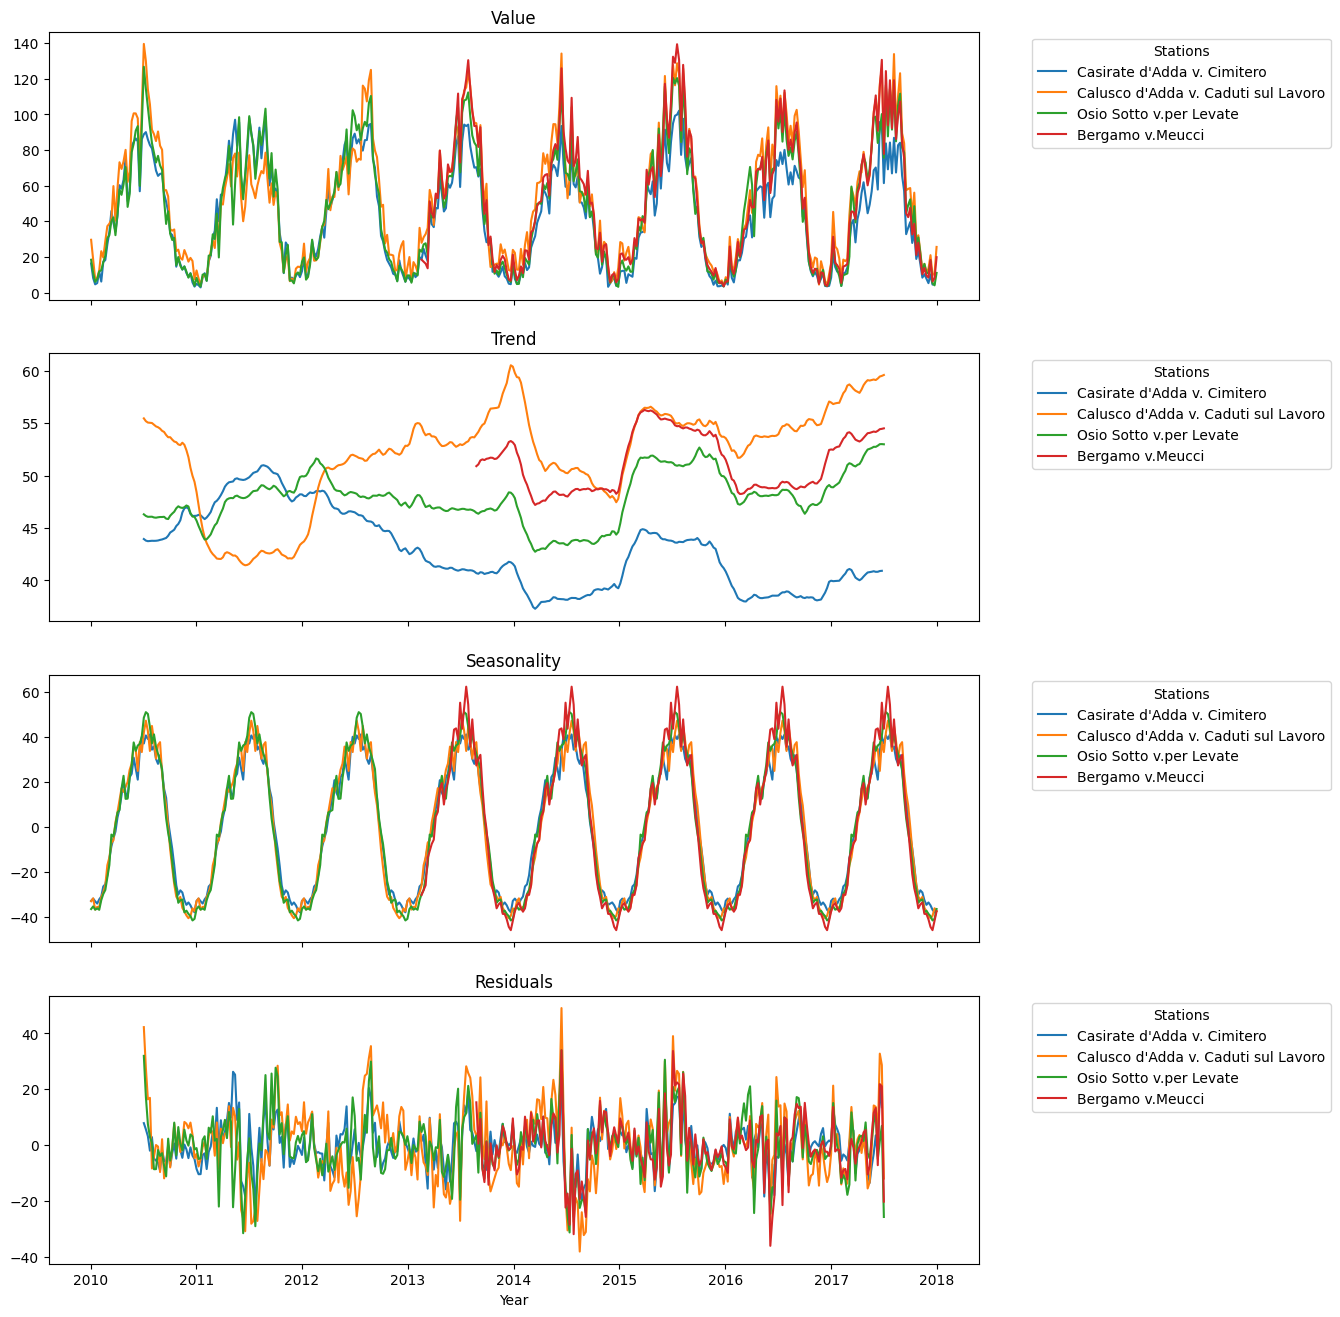

In [ ]:
df3 = gen_filtered_df(df=df_cleaned, provs=['BG']) # Example (Important to set df to df_cleaned!)
plot_decomposition(df3)

## IV.4. Spatial Analysis

In [ ]:
gdf['Valore'] = df['Valore']

# Create a spatial weights matrix
w = Queen.from_dataframe(gdf)
w.transform = 'r'

mi = Moran(gdf['Valore'], w)
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")
# Moran's I: The value of 0.0272 suggests a positive spatial autocorrelation
# value of 0.219 suggests that there is no strong evidence to reject the null hypothesis of spatial randomness

# it is possible that there is a weak tendency for nearby locations to have similar ozone values

Moran's I: 0.027209843030718776, p-value: 0.239


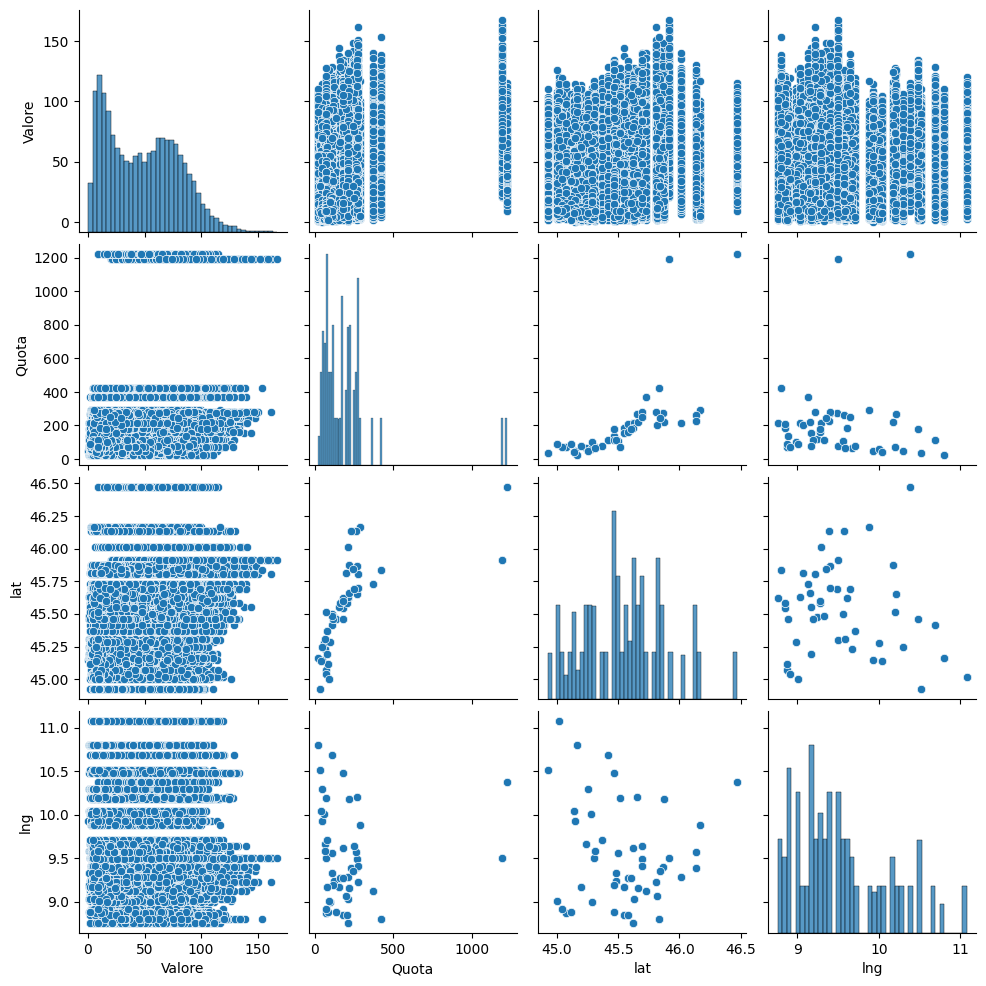

In [ ]:
sns.pairplot(df[['Valore', 'Quota', 'lat', 'lng']])
plt.show()

          Valore     Quota       lat       lng
Valore  1.000000  0.170907  0.075135  0.016911
Quota   0.170907  1.000000  0.667184  0.050463
lat     0.075135  0.667184  1.000000 -0.108752
lng     0.016911  0.050463 -0.108752  1.000000


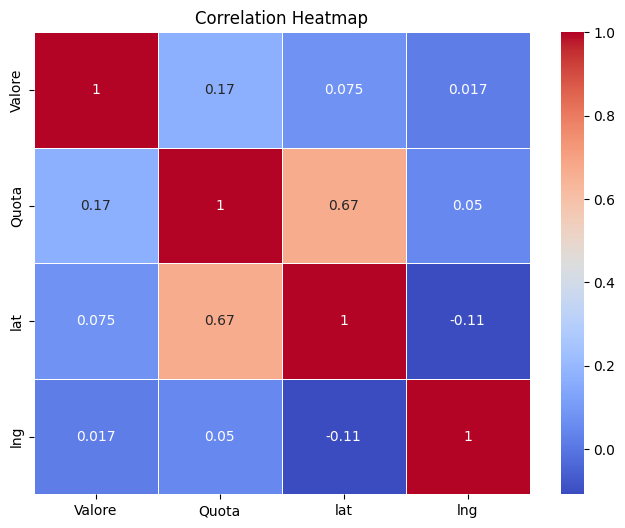

In [ ]:
# Create a correlation heatmap
correlation_matrix = df[['Valore', 'Quota', 'lat', 'lng']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# V. Final merges of the data

## V.1. Importing and merging data from API

In [14]:
file_id = '1m-ODcSC9b3aGV4UzLsiWDBa3rzZcytMZ'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'weather_data.csv'
gdown.download(url, output, quiet=False)

# Creating the dataframe for the weather data
weather_df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1m-ODcSC9b3aGV4UzLsiWDBa3rzZcytMZ
To: c:\Users\nb23N\Downloads\weather_data.csv
100%|██████████| 13.3M/13.3M [00:07<00:00, 1.75MB/s]


In [15]:
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df.set_index('time', inplace=True)

col = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)', 'sunshine_duration (s)', 'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)']

# Putting df for each location_id
weekly_list = []


for location_id, group_df in weather_df.groupby('location_id'):

    df_weekly_location = group_df[col].resample('W').mean()
    df_weekly_location[['location_id', 'lat', 'lng', 'elevation']] = group_df[['location_id', 'lat', 'lng', 'elevation']].resample('W').first()
    df_weekly_location.reset_index(inplace=True)
    # Just obtaining the date, we don't need time
    df_weekly_location['time'] = df_weekly_location['time'].dt.date

    weekly_list.append(df_weekly_location)

# Create the final weather dataframe
df_weather = pd.concat(weekly_list)
df_weather.drop(columns=['lat', 'lng', 'elevation'], inplace=True)

In [16]:
# Sort df just to be sure
df.sort_values(['idSensore', 'Data'], inplace=True)
# Initialize new column (useful just for merging later)
df['location_id'] = -1

current_location_id = 0
current_coordinate = df.location[0] # Gets first pair of coordinates in the dataframe

# Assign the value to the attribute location_id, then increase it each time the coordinates change (being ordered by idSensore we know that they are not scattered)
for idx, row in df.iterrows():
    if row['location'] != current_coordinate:
        current_location_id += 1
        current_coordinate = row['location']
    df.at[idx, 'location_id'] = current_location_id

In [17]:
# Again I check that the format is good for doing stuff
df['Data'] = pd.to_datetime(df['Data'])
df_weather['time'] = pd.to_datetime(df_weather['time'])

# Join the 2 dataframes, then drop 'time' column since it's the same as 'Data' in the new complete dataframe
df_final = pd.merge(df, df_weather, left_on=['location_id', 'Data'], right_on=['location_id', 'time'], how='inner')
df_final.drop('time', axis=1, inplace=True)

In [18]:
file_id = '1Se7oLGESmsMrmit6igAJTtrNCM8Mqvcy'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'humidity.csv'
gdown.download(url, output, quiet=False)

# Creating the dataframe for the weather data
humidity_df = pd.read_csv(output, skiprows=53)
humidity_df

Downloading...
From: https://drive.google.com/uc?id=1Se7oLGESmsMrmit6igAJTtrNCM8Mqvcy
To: c:\Users\nb23N\Downloads\humidity.csv
100%|██████████| 81.6M/81.6M [00:47<00:00, 1.70MB/s]


location_id              time  relative_humidity_2m (%)
0                  0  2010-01-01T00:00                       100
1                  0  2010-01-01T01:00                        99
2                  0  2010-01-01T02:00                        99
3                  0  2010-01-01T03:00                        98
4                  0  2010-01-01T04:00                        98
...              ...               ...                       ...
3576523           50  2017-12-31T19:00                        92
3576524           50  2017-12-31T20:00                        93
3576525           50  2017-12-31T21:00                        94
3576526           50  2017-12-31T22:00                        90
3576527           50  2017-12-31T23:00                        92

[3576528 rows x 3 columns]

In [19]:
humidity_df['time'] = pd.to_datetime(humidity_df['time'])
humidity_df = humidity_df.groupby(['location_id', pd.Grouper(key='time', freq='W')])['relative_humidity_2m (%)'].mean().reset_index()
humidity_df

location_id       time  relative_humidity_2m (%)
0                0 2010-01-03                 66.194444
1                0 2010-01-10                 86.428571
2                0 2010-01-17                 90.065476
3                0 2010-01-24                 89.095238
4                0 2010-01-31                 78.690476
...            ...        ...                       ...
21313           50 2017-12-03                 74.541667
21314           50 2017-12-10                 74.821429
21315           50 2017-12-17                 86.767857
21316           50 2017-12-24                 67.291667
21317           50 2017-12-31                 79.619048

[21318 rows x 3 columns]

In [20]:
# Again I check that the format is good for doing stuff
df_final['Data'] = pd.to_datetime(df_final['Data'])
humidity_df['time'] = pd.to_datetime(humidity_df['time'])

# Join the 2 dataframes, then drop 'time' column since it's the same as 'Data' in the new complete dataframe
df_final = pd.merge(df_final, humidity_df, left_on=['location_id', 'Data'], right_on=['location_id', 'time'], how='inner')
df_final.drop('time', axis=1, inplace=True)

# Hopefully this is the full dataframe with all meteorological data we need
df_final

index  idSensore     Valore       Data  Unnamed: 0 NomeTipoSensore  \
0          0     5707.0  17.546479 2010-01-03       305.0           Ozono   
1          1     5707.0   6.390476 2010-01-10       305.0           Ozono   
2          2     5707.0   4.245752 2010-01-17       305.0           Ozono   
3          3     5707.0   2.885246 2010-01-24       305.0           Ozono   
4          4     5707.0  18.532824 2010-01-31       305.0           Ozono   
...      ...        ...        ...        ...         ...             ...   
20209  33240    30165.0   6.484524 2017-12-03       362.0           Ozono   
20210  33241    30165.0   5.957143 2017-12-10       362.0           Ozono   
20211  33242    30165.0   1.448000 2017-12-17       362.0           Ozono   
20212  33243    30165.0   3.500794 2017-12-24       362.0           Ozono   
20213  33244    30165.0   9.197333 2017-12-31       362.0           Ozono   

      UnitaMisura  Idstazione              NomeStazione  Quota  ...  \
0           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
1           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
2           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
3           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
4           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
...           ...         ...                       ...    ...  ...   
20209       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20210       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20211       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20212       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20213       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   

      rain_sum (mm) snowfall_sum (cm) wind_speed_10m_max (km/h)  \
0          0.000000              0.00                 16.600000   
1          6.228571              1.25                 10.300000   
2          0.500000              0.00                  7.657143   
3          0.000000              0.00                  6.842857   
4          0.000000              0.14                 11.428571   
...             ...               ...                       ...   
20209      0.942857              0.00                  8.985714   
20210      0.100000              0.48                 13.000000   
20211      4.600000              0.52                 15.357143   
20212      0.000000              0.00                 10.471429   
20213      3.628571              0.07                 13.657143   

      temperature_2m_mean (°C) apparent_temperature_max (°C)  \
0                     1.166667                      0.600000   
1                     1.171429                      1.142857   
2                     1.514286                      2.342857   
3                    -0.128571                      1.014286   
4                     0.285714                      0.814286   
...                        ...                           ...   
20209                 3.242857                      3.900000   
20210                 2.942857                      4.228571   
20211                 3.800000                      5.185714   
20212                 1.871429                      3.414286   
20213                 3.857143                      4.771429   

       sunshine_duration (s)  wind_gusts_10m_max (km/h)  \
0               18344.020000                  30.266667   
1               13517.521429                  18.357143   
2               15706.524286                  14.600000   
3               24481.681429                  13.742857   
4               23378.441429                  21.814286   
...                      ...                        ...   
20209           15369.647143                  17.471429   
20210           20773.317143                  24.028571   
20211           18722.732857                  32.342857   
20212           26473.728571                  17.228571   
20213 

# VI. Final Data analysis

                             Valore     Quota  precipitation_sum (mm)  \
Valore                     1.000000  0.170907               -0.015311   
Quota                      0.170907  1.000000                0.121128   
precipitation_sum (mm)    -0.015311  0.121128                1.000000   
rain_sum (mm)              0.010350  0.075640                0.978151   
snowfall_sum (cm)         -0.124498  0.225373                0.165451   
wind_speed_10m_max (km/h)  0.139479 -0.311210                0.035898   
wind_gusts_10m_max (km/h)  0.325215  0.249705                0.268806   

                           rain_sum (mm)  snowfall_sum (cm)  \
Valore                          0.010350          -0.124498   
Quota                           0.075640           0.225373   
precipitation_sum (mm)          0.978151           0.165451   
rain_sum (mm)                   1.000000          -0.043119   
snowfall_sum (cm)              -0.043119           1.000000   
wind_speed_10m_max (km/h)       0.062

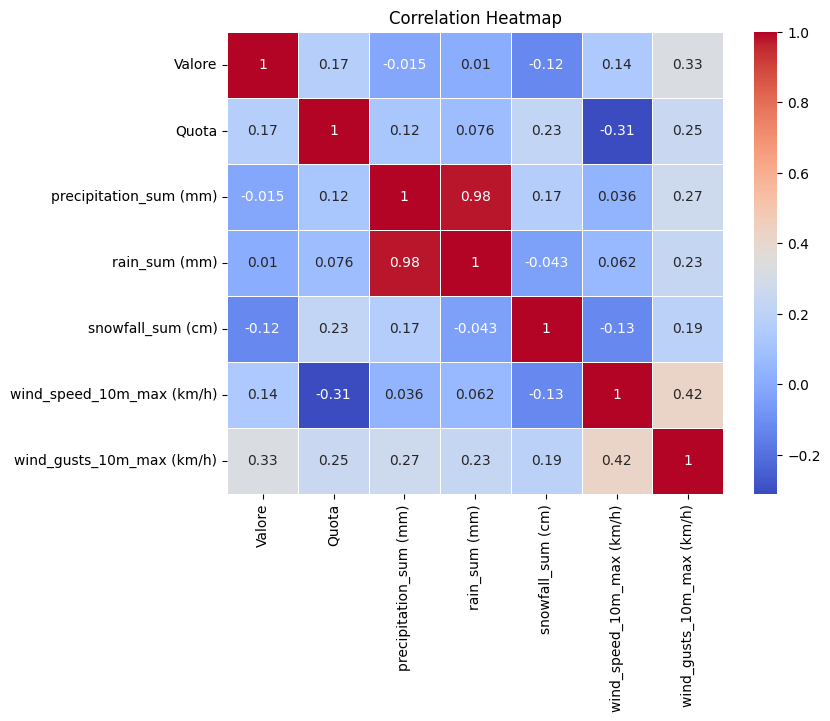

In [ ]:
# Create a correlation heatmap
correlation_matrix = df_final[['Valore', 'Quota', 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

                                   Valore  temperature_2m_mean (°C)  \
Valore                           1.000000                  0.766176   
temperature_2m_mean (°C)         0.766176                  1.000000   
apparent_temperature_max (°C)    0.777301                  0.993901   
sunshine_duration (s)            0.825705                  0.764010   
wind_direction_10m_dominant (°) -0.096128                 -0.152327   
shortwave_radiation_sum (MJ/m²)  0.887438                  0.806422   

                                 apparent_temperature_max (°C)  \
Valore                                                0.777301   
temperature_2m_mean (°C)                              0.993901   
apparent_temperature_max (°C)                         1.000000   
sunshine_duration (s)                                 0.799303   
wind_direction_10m_dominant (°)                      -0.123886   
shortwave_radiation_sum (MJ/m²)                       0.830425   

                                 sunshi

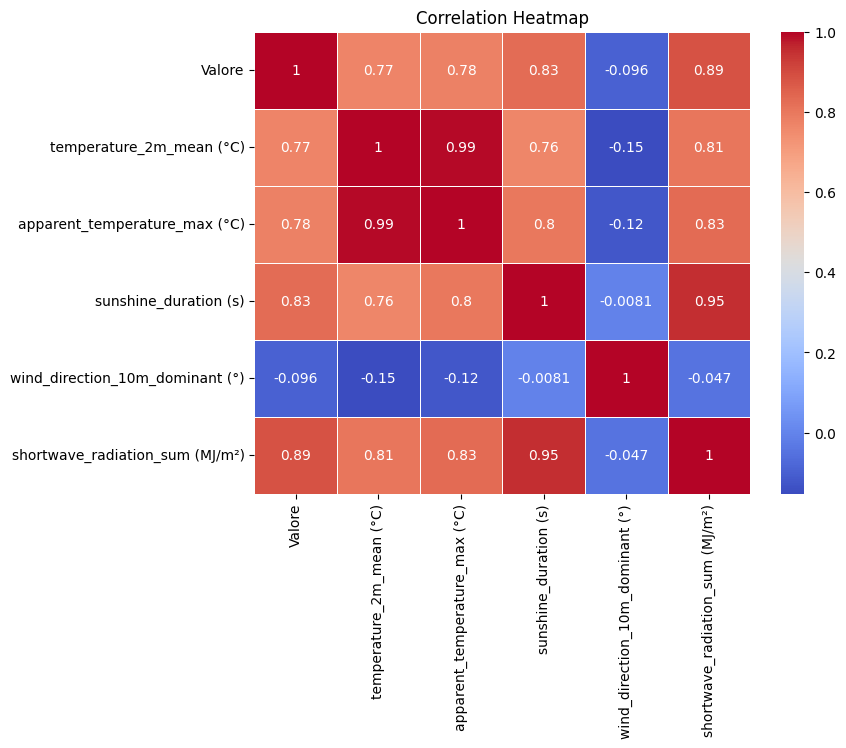

In [ ]:
# Create a correlation heatmap
correlation_matrix = df_final[['Valore', 'temperature_2m_mean (°C)',
       'apparent_temperature_max (°C)', 'sunshine_duration (s)', 'wind_direction_10m_dominant (°)',
       'shortwave_radiation_sum (MJ/m²)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

                                   Valore  temperature_2m_mean (°C)     Quota  \
Valore                           1.000000                  0.766176  0.170907   
temperature_2m_mean (°C)         0.766176                  1.000000 -0.176853   
Quota                            0.170907                 -0.176853  1.000000   
rain_sum (mm)                    0.010350                  0.097607  0.075640   
wind_speed_10m_max (km/h)        0.139479                  0.137344 -0.311210   
wind_gusts_10m_max (km/h)        0.325215                  0.149090  0.249705   
shortwave_radiation_sum (MJ/m²)  0.887438                  0.806422 -0.007822   
relative_humidity_2m (%)        -0.603761                 -0.471010  0.072238   

                                 rain_sum (mm)  wind_speed_10m_max (km/h)  \
Valore                                0.010350                   0.139479   
temperature_2m_mean (°C)              0.097607                   0.137344   
Quota                                 0

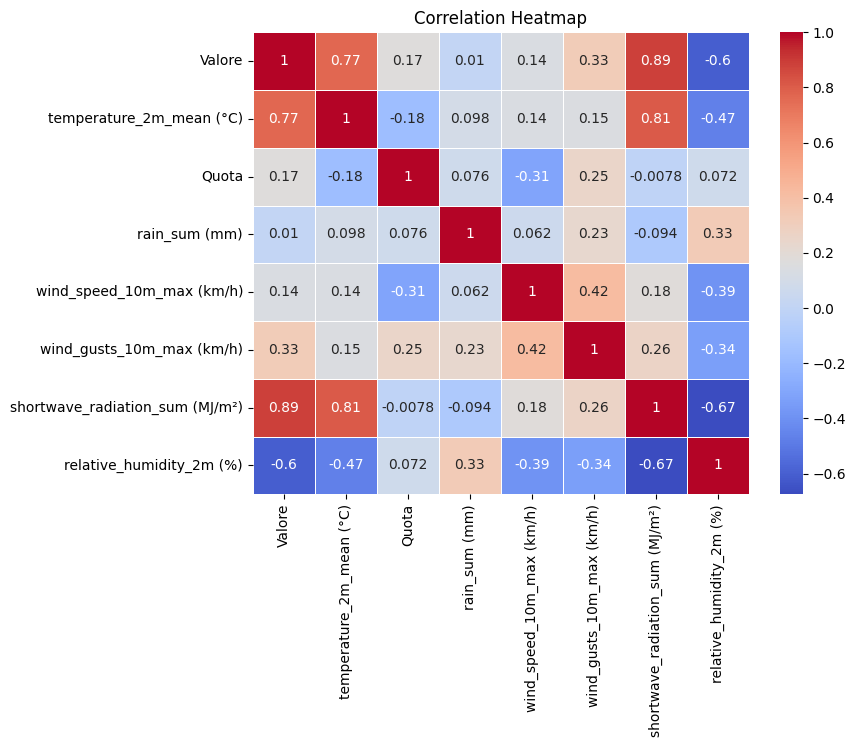

In [ ]:
# This could be the most suitable one, let me guys know
correlation_matrix = df_final[['Valore', 'temperature_2m_mean (°C)', 'Quota', 'rain_sum (mm)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df_final.columns

Index(['index', 'idSensore', 'Valore', 'Data', 'Unnamed: 0', 'NomeTipoSensore',
       'UnitaMisura', 'Idstazione', 'NomeStazione', 'Quota', 'Provincia',
       'Comune', 'Storico', 'DataStart', 'DataStop', 'Utm_Nord', 'UTM_Est',
       'lat', 'lng', 'location', 'BoxCoxValore', 'geometry', 'location_id',
       'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)',
       'apparent_temperature_max (°C)', 'sunshine_duration (s)',
       'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
       'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)'],
      dtype='object')

In [ ]:
df_final.head(3)

index  idSensore     Valore       Data  Unnamed: 0 NomeTipoSensore  \
0      0     5707.0  17.546479 2010-01-03       305.0           Ozono   
1      1     5707.0   6.390476 2010-01-10       305.0           Ozono   
2      2     5707.0   4.245752 2010-01-17       305.0           Ozono   

  UnitaMisura  Idstazione            NomeStazione  Quota  ... rain_sum (mm)  \
0       µg/m³       551.0  Arconate v. De Gasperi  182.0  ...      0.000000   
1       µg/m³       551.0  Arconate v. De Gasperi  182.0  ...      6.228571   
2       µg/m³       551.0  Arconate v. De Gasperi  182.0  ...      0.500000   

  snowfall_sum (cm) wind_speed_10m_max (km/h) temperature_2m_mean (°C)  \
0              0.00                 16.600000                 1.166667   
1              1.25                 10.300000                 1.171429   
2              0.00                  7.657143                 1.514286   

  apparent_temperature_max (°C)  sunshine_duration (s)  \
0                      0.600000           18344.020000   
1                      1.142857           13517.521429   
2                      2.342857           15706.524286   

   wind_gusts_10m_max (km/h)  wind_direction_10m_dominant (°)  \
0                  30.266667                       221.000000   
1                  18.357143                       192.142857   
2                  14.600000                       149.857143   

   shortwave_radiation_sum (MJ/m²) relative_humidity_2m (%)  
0                         5.136667                66.194444  
1                         3.511429                86.428571  
2                         4.060000                90.065476  

[3 rows x 34 columns]

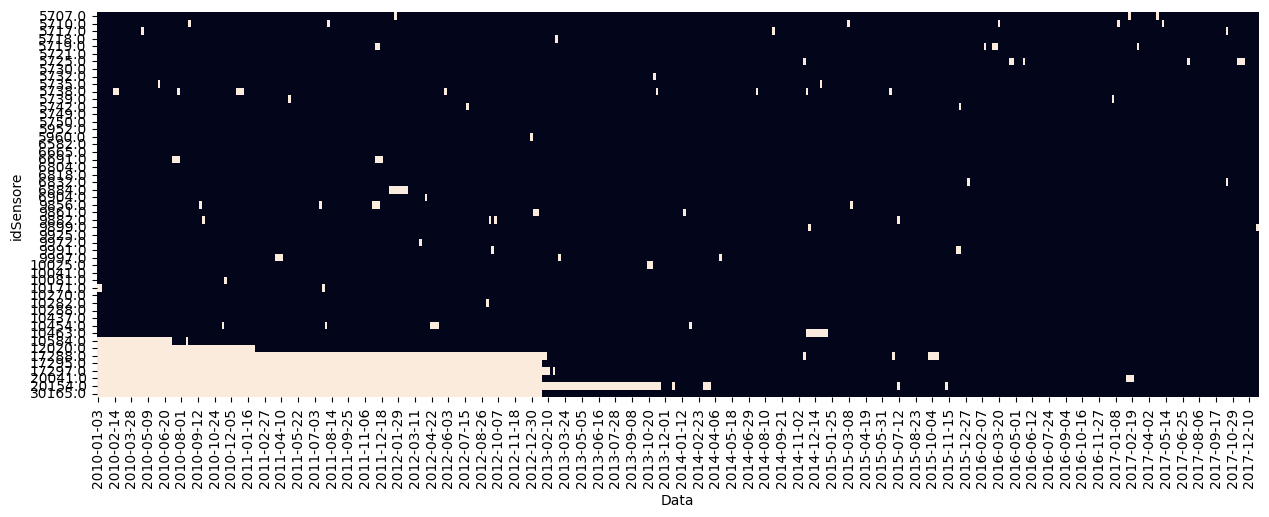

In [ ]:
DF = df_final.copy()
DF["Data"] = DF["Data"].astype(str)
pivoted_df = DF.pivot(index='idSensore', columns="Data", values='Valore')
plt.figure(figsize=(15, 5))
sns.heatmap(pivoted_df.isnull(), cbar=False, yticklabels=True)
plt.show()

# VII. Defining Data for stan model

In [21]:
def standardize_columns(input_df=None):
    """
    Standardizes specified columns in a DataFrame using StandardScaler.

    Parameters:
    - input_df: pd.DataFrame, optional
        The input DataFrame. Default is df_final.

    Returns:
    - pd.DataFrame
        The DataFrame with specified columns standardized.
    """
    # If input_df is not provided, use df_final
    if input_df is None:
        input_df = df_final.copy()

    # Specify columns to standardize
    columns_to_standardize = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
                               'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)',
                               'apparent_temperature_max (°C)', 'sunshine_duration (s)',
                               'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
                               'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']

    # Create a copy of the input DataFrame to avoid modifying the original
    standardized_df = input_df.copy()

    # Standardize specified columns
    scaler = StandardScaler()
    standardized_df[columns_to_standardize] = scaler.fit_transform(standardized_df[columns_to_standardize])

    return standardized_df

In [22]:
def filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, input_df):
    """
    Filters a DataFrame based on a date range and includes specified columns.

    Parameters:
    - start_date: str
        The start date in 'YYYY-MM-DD' format.
    - end_date: str
        The end date in 'YYYY-MM-DD' format.
    - columns_to_include: list
        A list of column names to include in the final result.
    - input_df: pd.DataFrame, optional
        The input DataFrame to be filtered. Default is None, which uses df_final.

    Returns:
    - pd.DataFrame
        The filtered DataFrame with specified columns.
    """
    # If input_df is not provided, use df_final
    if input_df is None:
        input_df = df_final.copy()

    # Ensure 'Data' column is in datetime format
    input_df['Data'] = pd.to_datetime(input_df['Data'])

    # Filter rows between two dates
    filtered_df = input_df[(input_df['Data'] >= start_date) & (input_df['Data'] <= end_date)]

    # Select specified columns
    filtered_df = filtered_df[columns_to_include]

    return filtered_df

In [23]:
def process_and_add_deltas(df, date_column='Data', sensor_id_column='idSensore', columns_to_increment=None):
    """
    Sorts the DataFrame by sensor ID and date, adds weekly increments for specified columns,
    and replaces NaN values with zeros.

    Parameters:
    - df: pd.DataFrame
        The input DataFrame to be processed.
    - date_column: str, optional
        The name of the column containing date information. Default is 'Data'.
    - sensor_id_column: str, optional
        The name of the column containing sensor IDs. Default is 'idSensore'.
    - columns_to_increment: list, optional
        A list of column names for which weekly increments should be calculated.

    Returns:
    - pd.DataFrame
        The processed DataFrame with added weekly increments and NaN values replaced by zeros.
    """
    # Sort the DataFrame by sensor ID and date
    df.sort_values(by=[sensor_id_column, date_column], inplace=True)

    # Default columns to increment if not provided
    if columns_to_increment is None:
        columns_to_increment = ['temperature_2m_mean (°C)']

    # Creating for each weather variable, a column that has the weekly increments wrt week before
    for i, column in enumerate(columns_to_increment, start=1):
        delta_column = f'delta_{i}'
        df[delta_column] = df.groupby(sensor_id_column)[column].diff()

    # For the first row of a sensor's measurement, set the increment value to 0
    df.loc[df[sensor_id_column].diff() != 0, [f'delta_{i}' for i in range(1, len(columns_to_increment) + 1)]] = 0

    return df

In [24]:
def fill_valore_array(data_df):
    """
    Fills a 3D NumPy array based on DataFrame values.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing the values to fill the array.
    - valore_array_shape: tuple, optional
        The shape of the NumPy array to be filled. Default is (1, None, None).

    Returns:
    - np.ndarray
        The filled 3D NumPy array.
    """
    years = data_df['Data'].dt.year.unique()
    sensors = data_df['idSensore'].unique()

    if (len(years) == 1):
      # Extract unique sensor IDs and weeks
      weeks = data_df['Data'].unique()

      valore_array_shape = (1, len(weeks), len(sensors))

      # Create an array of zeros based on the specified shape
      valore_array = np.zeros(valore_array_shape)

      # Fill the array based on DataFrame values
      for index, row in data_df.iterrows():
          year_index = 0  # Assuming year index is always 0
          week_index = np.where(weeks == row['Data'])[0][0]
          sensor_index = np.where(sensors == row['idSensore'])[0][0]

          valore_array[year_index, week_index, sensor_index] = row['Valore_log']

      return valore_array
    elif (len(years) > 1):
      # Create a dictionary to store DataFrames for each year
      yearly_data = {year: data_df[data_df['Data'].dt.year == year] for year in years}
      year_index = 0
      valore_array_shape = (len(years), 53, len(sensors))
      # Create an array of zeros based on the specified shape
      valore_array = np.zeros(valore_array_shape)
      for y in years:
        subset_df = yearly_data[y]
        weeks = subset_df['Data'].unique()

        # Fill the array based on DataFrame values
        for index, row in subset_df.iterrows():
            week_index = np.where(weeks == row['Data'])[0][0]
            sensor_index = np.where(sensors == row['idSensore'])[0][0]

            valore_array[year_index, week_index, sensor_index] = row['Valore_log']

        year_index += 1

      return valore_array

In [25]:
def fill_delta_array(processed_df, n_covariates=4):
    """
    Creates a 4D NumPy array (delta_array) based on processed DataFrame values.

    Parameters:
    - processed_df: pd.DataFrame
        The processed DataFrame containing delta values.
    - n_covariates: int, optional
        The number of covariates. Default is 4.

    Returns:
    - np.ndarray
        The 4D NumPy array containing delta values.
    """
    # Extract unique sensor IDs and weeks
    years = processed_df['Data'].dt.year.unique()
    sensors = processed_df['idSensore'].unique()

    if (len(years) == 1):
      weeks = processed_df['Data'].unique()

      delta_array = np.zeros((1, len(weeks), len(sensors), n_covariates))

      for index, row in processed_df.iterrows():
          year_index = 0
          week_index = np.where(weeks == row['Data'])[0][0]
          sensor_index = np.where(sensors == row['idSensore'])[0][0]

          # Iterate through all columns starting with 'delta_'
          for col_name in processed_df.columns:
              if col_name.startswith('delta_'):
                  # Extract the covariate index from the column name
                  covariate_index = int(col_name.split('_')[1]) - 1  # Subtract 1 to convert from 1-based to 0-based index

                  # Assign values to the delta_array
                  delta_array[year_index][week_index][sensor_index][covariate_index] = row[col_name]

      return delta_array

    elif (len(years) > 1):
      # Create a dictionary to store DataFrames for each year
      yearly_data = {year: processed_df[processed_df['Data'].dt.year == year] for year in years}
      year_index = 0
      delta_array = np.zeros((len(years), 53, len(sensors), n_covariates))

      for y in years:
        subset_df = yearly_data[y]
        weeks = subset_df['Data'].unique()

        for index, row in subset_df.iterrows():
            week_index = np.where(weeks == row['Data'])[0][0]
            sensor_index = np.where(sensors == row['idSensore'])[0][0]

            # Iterate through all columns starting with 'delta_'
            for col_name in subset_df.columns:
                if col_name.startswith('delta_'):
                    # Extract the covariate index from the column name
                    covariate_index = int(col_name.split('_')[1]) - 1  # Subtract 1 to convert from 1-based to 0-based index

                    # Assign values to the delta_array
                    delta_array[year_index][week_index][sensor_index][covariate_index] = row[col_name]
        year_index += 1

      return delta_array

In [26]:
def calculate_distance_matrix(data_df, id_column='location_id', location_column='location'):
    """
    Calculates the Euclidean distance matrix based on location data in a DataFrame.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing location data.
    - id_column: str, optional
        The name of the column containing IDs. Default is 'location_id'.
    - location_column: str, optional
        The name of the column containing location information. Default is 'location'.

    Returns:
    - pd.DataFrame
        The Euclidean distance matrix.
    """
    # Drop duplicates to get unique ID-value pairs
    unique_df_location = data_df[[id_column, location_column]].drop_duplicates()

    # Function to parse string and extract latitude, longitude as tuple
    def parse_point(point_str):
        lat, lon = map(float, point_str.strip('()').split(','))
        return lat, lon

    # Function to calculate Euclidean distance between two points
    def euclidean_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    # Parse points and compute distance matrix
    unique_df_location[location_column] = unique_df_location[location_column].apply(parse_point)
    points = unique_df_location[location_column].tolist()

    distance_matrix = pd.DataFrame(
        [[euclidean_distance(p1, p2) for p2 in points] for p1 in points],
        columns=unique_df_location[id_column], index=unique_df_location[id_column]
    )

    return distance_matrix

In [27]:
def calculate_distance_matrix_pred(data_df, data_df_to_pred, id_column='location_id', location_column='location'):
    """
    Calculates the Euclidean distance matrix based on location data in a DataFrame.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing location data.
    - data_df_to_pred: pd.DataFrame
        The DataFrame containing location data on which we want to do prediction
    - id_column: str, optional
        The name of the column containing IDs. Default is 'location_id'.
    - location_column: str, optional
        The name of the column containing location information. Default is 'location'.

    Returns:
    - pd.DataFrame
        The Euclidean distance matrix.
    """
    # Drop duplicates to get unique ID-value pairs
    unique_df_location = data_df[[id_column, location_column]].drop_duplicates()
    unique_df_to_pred_location = data_df_to_pred[[id_column, location_column]].drop_duplicates()

    # Function to parse string and extract latitude, longitude as tuple
    def parse_point(point_str):
        lat, lon = map(float, point_str.strip('()').split(','))
        return lat, lon

    # Function to calculate Euclidean distance between two points
    def euclidean_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    # Parse points and compute distance matrix
    unique_df_location[location_column] = unique_df_location[location_column].apply(parse_point)
    points = unique_df_location[location_column].tolist()
    unique_df_to_pred_location[location_column] = unique_df_to_pred_location[location_column].apply(parse_point)
    points_to_pred = unique_df_to_pred_location[location_column].tolist()

    distance_matrix = pd.DataFrame(
        [[euclidean_distance(p1, p2) for p2 in points] for p1 in points_to_pred],
        columns=unique_df_location[id_column], index=unique_df_to_pred_location[id_column]
    )

    return distance_matrix

# VIII. Implementing Stan model

In [28]:
%pip install --upgrade cmdstanpy arviz

Note: you may need to restart the kernel to use updated packages.


In [29]:
# Required modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Required functions
from cmdstanpy import CmdStanModel

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [ ]:
# GP-AR Spatio-Temporal Model with Stan

from cmdstanpy import install_cmdstan
%conda install cmdstan -c conda-forge

In [117]:
spt_lm = \
"""
data {
    int<lower=0> N_years;
    int<lower=0> N_weeks;
    int<lower=0> N_stations;
    int<lower=0> N_covariates;

    int<lower=0> N_years_to_pred;
    int<lower=0> N_weeks_to_pred;
    int<lower=0> N_stations_to_pred;

    array[N_years,N_weeks,N_stations] real y;
    array[N_years,N_weeks] matrix[N_stations,N_covariates] delta;
    matrix[N_stations,N_stations] dist; //distance matrix

    matrix[N_stations_to_pred, N_stations] dist_pred; // distance matrix which represents the distance from the stations to predict to every other station in the data set
    matrix[N_stations_to_pred, N_stations_to_pred] dist_pred_to_pred; // distance matrix which represents the distance between the stations to predict
    vector[N_weeks_to_pred] weeks_to_pred; // represents the time on which we want to perform prediction

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> s0;
    real<lower=0> phi_gamma_esti;
    real<lower=0> phi_eta_esti;
}

parameters {
    real<lower=0,upper=1> rho;
    array[N_years] real xi;
    array[N_covariates] real beta;
    array[N_years,N_weeks,N_stations] real eta;
    array[N_years] real mu;
    array[N_years,N_stations] real gamma;

    matrix[N_covariates, N_covariates] A_raw;  // Lower triangular matrix elements (raw scale)
    array[N_covariates] real phi_delta;

    real<lower=0> tau_eta;
    real<lower=0> tau_gamma;
    real<lower=0> tau_epsilon;
}

transformed parameters {
    matrix[N_stations,N_stations] Sigma_eta;
    matrix[N_stations,N_stations] Sigma_gamma;
    for (i in 1:N_stations){
        for (j in 1:N_stations){
            Sigma_eta[i,j]=(1/tau_eta)*exp(-phi_eta_esti*dist[i,j]);
            Sigma_gamma[i,j]=(1/tau_gamma)*exp(-phi_gamma_esti*dist[i,j]);
        }
    }

    matrix[N_stations, N_stations] Sigma_delta;
    for(i in 1:N_stations){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist[i,j])*t_k;
        }
        Sigma_delta[i,j] = s;
      }
    }
}

model {
    vector[N_stations] zero = rep_vector(0,N_stations);
    rho ~ normal(0,1);
    xi ~ normal(0, s0);//check if a for loop is needed
    beta ~ normal(0, s0);//same
    tau_eta ~ gamma(a, b);
    tau_gamma ~ gamma(a, b);
    tau_epsilon ~ gamma(a, b);
    mu ~ normal(0,s0);//same
    // Priors for the elements of the lower triangular matrix
    for (j in 1:N_covariates) {
      for (i in 1:j) {
        A_raw[i, j] ~ normal(0, 1);  // Prior for the elements
      }
    }

    // Prior fo the phi_delta
    /*for (k in 1:N_covariates){
      phi_delta[k] ~ uniform(0.001,0.1);
    }*/
    // define the distribution of delta
    for (i in 1:N_years){
      for (j in 1:N_weeks){
        for (p in 1:N_covariates){
          delta[i][j][:, p] ~ multi_normal(zero, Sigma_gamma);
        }
      }
    }

    for (i in 1:N_years){
      for (j in 1:N_weeks){
        to_vector(eta[i][j]) ~ multi_normal(zero,Sigma_eta);
      }
    }
    for (i in 1:N_years){
      to_vector(gamma[i]) ~ multi_normal(zero,Sigma_gamma);
    }
    for (i in 1:N_years) {
      y[i][1] ~ normal(rep_vector(mu[i],N_stations)+to_vector(gamma[i]), 1/tau_epsilon);
      for (j in 2:N_weeks){
        y[i][j] ~ normal(rho*to_vector(y[i][j-1])+rep_vector(xi[i],N_stations)+delta[i][j]*to_vector(beta)+to_vector(eta[i][j]),1/tau_epsilon);//Check matrix product
      }
    }
}

generated quantities {
    vector[N_stations] zero = rep_vector(0,N_stations);
    // Posterior predictive distribution
    array[N_years_to_pred, N_stations_to_pred] real gamma_pred_sim; // represents values of gamma in a new location
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations,N_covariates] delta_pred_sim_t; // represents the array of prediction of delta value in new time
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations_to_pred,N_covariates] delta_pred_sim_s_t; // represents the array of prediction of delta value in new time and new location
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations] real o_pred_sim_t; // represents the O value predicted for new time
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations_to_pred] real o_pred_sim_s_t; // represents the O value predicted for a new location
    array[N_years_to_pred,N_weeks_to_pred,N_stations_to_pred] real y_pred_sim;// represents the array of values for ozon level predicted for new time and new location

    // Calculate the derived quantity Sigma_gamma_12
    matrix[N_stations_to_pred, N_stations] Sigma_gamma_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_gamma_12[i,j] = exp(-phi_gamma_esti * dist_pred[i][j]);
      }
    }

    // Claculate the derived quantity Sigma_eta_12
    matrix[N_stations_to_pred, N_stations] Sigma_eta_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_eta_12[i,j] = exp(-phi_eta_esti * dist_pred[i][j]);
      }
    }

    // Inverse of Sigma_gamma
    matrix[N_stations, N_stations] Sigma_gamma_inv;
    Sigma_gamma_inv = inverse(Sigma_gamma);

    // Inverse of Sigma_eta
    matrix[N_stations, N_stations] Sigma_eta_inv;
    Sigma_eta_inv = inverse(Sigma_eta);

    // Draw gamma_pred_sim from its posterior distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        gamma_pred_sim[i,j] = normal_rng(Sigma_gamma_12[i, ] * Sigma_gamma_inv * to_vector(gamma[i]), (1/tau_gamma) * (1 - Sigma_gamma_12[i, ] * Sigma_gamma_inv * Sigma_gamma_12[i, ]'));
      }
    }

    // Calculate the derivded quantity Sigma_delta_12
    matrix[N_stations_to_pred, N_stations] Sigma_delta_12;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred[i,j])*t_k;
        }
        Sigma_delta_12[i,j] = s;
      }
    }

    // Calculate the derivded quantity Sigma_delta_11
    matrix[N_stations_to_pred, N_stations_to_pred] Sigma_delta_11;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations_to_pred){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred_to_pred[i,j])*t_k;
        }
        Sigma_delta_11[i,j] = s;
      }
    }

    // Draw delta_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_t[i][j][:, p] = multi_normal_rng(zero, Sigma_delta);
        }
      }
    }
    // Draw delta_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_s_t[i][j][:, p] = multi_normal_rng(Sigma_delta_12 * inverse(Sigma_delta) * delta_pred_sim_t[i][j][:, p], Sigma_delta_11 - Sigma_delta_12 * inverse(Sigma_delta) * transpose(Sigma_delta_12));
        }
      }
    }

    // Draw o_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      o_pred_sim_t[i][1] = to_array_1d(to_vector(gamma[i]) + mu[i]);
      for (j in 2:to_int(max(weeks_to_pred))){
        o_pred_sim_t[i][j] = to_array_1d(multi_normal_rng(xi[i] + rho *  to_vector(o_pred_sim_t[i][j - 1]) + delta_pred_sim_t[i][j] * to_vector(beta), (1/tau_eta) * Sigma_eta));
      }
    }
    //Draw o_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        o_pred_sim_s_t[i][1][j] = gamma_pred_sim[i,j] + mu[i];
        for (t in 2:to_int(max(weeks_to_pred))){
          real G_delta = (1/tau_eta) * (1 - Sigma_eta_12[j, ] * Sigma_eta_inv * Sigma_eta_12[j, ]');
          real arg_1 = xi[i] + rho * o_pred_sim_s_t[i][t-1][j] + delta_pred_sim_s_t[i][t][j] * to_vector(beta);
          real arg_2 = Sigma_eta_12[j, ] * Sigma_eta_inv * (to_vector(o_pred_sim_t[i][j]) - xi[i] - rho *  to_vector(o_pred_sim_t[i][t - 1]) - delta_pred_sim_t[i][j] * to_vector(beta));
          real zeta = arg_1 + arg_2;
          o_pred_sim_s_t[i][t][j] = normal_rng(zeta, G_delta);
        }
      }
    }

    // Draw the Ozon Level in the new location and new time from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (k in 1:N_stations_to_pred){
          y_pred_sim[i][j][k] = normal_rng(o_pred_sim_s_t[i][to_int(weeks_to_pred[j])][k], 1/tau_epsilon);
        }
      }
    }
}
"""

# Write model to file
stan_file = "stan/spt_lm.stan"
with open(stan_file, "w") as f:
    print(spt_lm, file=f)

# Compile model
spt_lm_eff = CmdStanModel(stan_file=stan_file)

18:01:08 - cmdstanpy - INFO - compiling stan file C:\Users\nb23N\Downloads\stan\spt_lm.stan to exe file C:\Users\nb23N\Downloads\stan\spt_lm.exe
18:02:02 - cmdstanpy - INFO - compiled model executable: C:\Users\nb23N\Downloads\stan\spt_lm.exe


# IX. Preparing data and running the model

## IX.1. Split Data On train, test and validation

In [31]:
# FILLING MISSING VALUES

indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index

for indice in indici_righe_manca_valore:
    # Check if the indices before and after are not null
    if (indice - 1) in df_final.index and (indice + 1) in df_final.index:
        # Check if they have the same idSensore
        idSensore_corrente = df_final.at[indice, "idSensore"]
        idSensore_precedente = df_final.at[indice - 1, "idSensore"]
        idSensore_successivo = df_final.at[indice + 1, "idSensore"]

        if idSensore_corrente == idSensore_precedente == idSensore_successivo:
            # Compute the mean of the two "Valore" and fill the missing value
            valore_precedente = df_final.at[indice - 1, "Valore"]
            valore_successivo = df_final.at[indice + 1, "Valore"]
            media_valori = (valore_precedente + valore_successivo) / 2

            # Fill the missing value with the mean
            df_final.at[indice, "Valore"] = media_valori

In [32]:
indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index
print(indici_righe_manca_valore)

Index([ 1770,  1771,  1992,  1993,  2834,  2835,  2916,  2917,  2918,  4184,
        4185,  7962,  7963,  8034,  8035,  8036, 10532, 10533, 11007, 11008,
       12103, 13249, 13250, 13422, 13423, 13424, 13972, 13973, 15028, 15029,
       17238, 17239, 17240, 17791, 17792, 17793, 17794, 17795, 17796, 17797,
       17798, 17954, 17955, 18708, 18709, 18710, 18848, 18849, 18850, 18851,
       19225, 19226, 19227, 19693, 19694, 19695, 19756, 19757, 19758],
      dtype='int64')


In [33]:
spec=np.linspace(df_final.at[1769,'Valore'],df_final.at[1772,'Valore'], 4)
df_final.at[1770,'Valore']=spec[1]
df_final.at[1771,'Valore']=spec[2]
spec=np.linspace(df_final.at[1991,'Valore'],df_final.at[1994,'Valore'], 4)
df_final.at[1992,'Valore']=spec[1]
df_final.at[1993,'Valore']=spec[2]
spec=np.linspace(df_final.at[2833,'Valore'],df_final.at[2836,'Valore'], 4)
df_final.at[2834,'Valore']=spec[1]
df_final.at[2835,'Valore']=spec[2]
spec=np.linspace(df_final.at[4183,'Valore'],df_final.at[4186,'Valore'], 4)
df_final.at[4184,'Valore']=spec[1]
df_final.at[4185,'Valore']=spec[2]
spec=np.linspace(df_final.at[7961,'Valore'],df_final.at[7964,'Valore'], 4)
df_final.at[7962,'Valore']=spec[1]
df_final.at[7963,'Valore']=spec[2]
spec=np.linspace(df_final.at[10531,'Valore'],df_final.at[10534,'Valore'], 4)
df_final.at[10532,'Valore']=spec[1]
df_final.at[10533,'Valore']=spec[2]
spec=np.linspace(df_final.at[11006,'Valore'],df_final.at[11009,'Valore'], 4)
df_final.at[11007,'Valore']=spec[1]
df_final.at[11008,'Valore']=spec[2]
spec=np.linspace(df_final.at[13248,'Valore'],df_final.at[13251,'Valore'], 4)
df_final.at[13249,'Valore']=spec[1]
df_final.at[13250,'Valore']=spec[2]
spec=np.linspace(df_final.at[13422,'Valore'],df_final.at[13425,'Valore'], 4)
df_final.at[13423,'Valore']=spec[1]
df_final.at[13424,'Valore']=spec[2]
spec=np.linspace(df_final.at[13971,'Valore'],df_final.at[13974,'Valore'], 4)
df_final.at[13972,'Valore']=spec[1]
df_final.at[13973,'Valore']=spec[2]
df_final.at[15028,'Valore']=df_final.at[15030,'Valore']
df_final.at[15029,'Valore']=df_final.at[15030,'Valore']
df_final.at[17954,'Valore']=df_final.at[17956,'Valore']
df_final.at[17955,'Valore']=df_final.at[17956,'Valore']
spec=np.linspace(df_final.at[2915,'Valore'],df_final.at[2919,'Valore'], 5)
df_final.at[2916,'Valore']=spec[1]
df_final.at[2917,'Valore']=spec[2]
df_final.at[2918,'Valore']=spec[3]
spec=np.linspace(df_final.at[8033,'Valore'],df_final.at[8037,'Valore'], 5)
df_final.at[8034,'Valore']=spec[1]
df_final.at[8035,'Valore']=spec[2]
df_final.at[8036,'Valore']=spec[3]
spec=np.linspace(df_final.at[13421,'Valore'],df_final.at[13425,'Valore'], 5)
df_final.at[13422,'Valore']=spec[1]
df_final.at[13423,'Valore']=spec[2]
df_final.at[13424,'Valore']=spec[3]
spec=np.linspace(df_final.at[17237,'Valore'],df_final.at[17241,'Valore'], 5)
df_final.at[17238,'Valore']=spec[1]
df_final.at[17239,'Valore']=spec[2]
df_final.at[17240,'Valore']=spec[3]
df_final.at[18708,'Valore']=df_final.at[18711,'Valore']
df_final.at[18709,'Valore']=df_final.at[18711,'Valore']
df_final.at[18710,'Valore']=df_final.at[18711,'Valore']
df_final.at[19225,'Valore']=df_final.at[19228,'Valore']
df_final.at[19226,'Valore']=df_final.at[19228,'Valore']
df_final.at[19227,'Valore']=df_final.at[19228,'Valore']
spec=np.linspace(df_final.at[19692,'Valore'],df_final.at[19696,'Valore'], 5)
df_final.at[19693,'Valore']=spec[1]
df_final.at[19694,'Valore']=spec[2]
df_final.at[19695,'Valore']=spec[3]
spec=np.linspace(df_final.at[19755,'Valore'],df_final.at[19759,'Valore'], 5)
df_final.at[19756,'Valore']=spec[1]
df_final.at[19757,'Valore']=spec[2]
df_final.at[19758,'Valore']=spec[3]
spec=np.linspace(df_final.at[18847,'Valore'],df_final.at[18852,'Valore'], 6)
df_final.at[18848,'Valore']=spec[1]
df_final.at[18849,'Valore']=spec[2]
df_final.at[18850,'Valore']=spec[3]
df_final.at[18851,'Valore']=spec[4]
spec=np.linspace(df_final.at[17790,'Valore'],df_final.at[17799,'Valore'], 10)
df_final.at[17791,'Valore']=spec[1]
df_final.at[17792,'Valore']=spec[2]
df_final.at[17793,'Valore']=spec[3]
df_final.at[17794,'Valore']=spec[4]
df_final.at[17795,'Valore']=spec[5]
df_final.at[17796,'Valore']=spec[6]
df_final.at[17797,'Valore']=spec[7]
df_final.at[17798,'Valore']=spec[8]
df_final.at[12103,'Valore']=df_final.at[12102,'Valore']

In [34]:
# Apply the log transformation as per the model
df_final['Valore_log'] = np.log(df_final['Valore'].replace(0, np.nan))

# Hopefully this is the full dataframe with all meteorological data we need
df_final

index  idSensore     Valore       Data  Unnamed: 0 NomeTipoSensore  \
0          0     5707.0  17.546479 2010-01-03       305.0           Ozono   
1          1     5707.0   6.390476 2010-01-10       305.0           Ozono   
2          2     5707.0   4.245752 2010-01-17       305.0           Ozono   
3          3     5707.0   2.885246 2010-01-24       305.0           Ozono   
4          4     5707.0  18.532824 2010-01-31       305.0           Ozono   
...      ...        ...        ...        ...         ...             ...   
20209  33240    30165.0   6.484524 2017-12-03       362.0           Ozono   
20210  33241    30165.0   5.957143 2017-12-10       362.0           Ozono   
20211  33242    30165.0   1.448000 2017-12-17       362.0           Ozono   
20212  33243    30165.0   3.500794 2017-12-24       362.0           Ozono   
20213  33244    30165.0   9.197333 2017-12-31       362.0           Ozono   

      UnitaMisura  Idstazione              NomeStazione  Quota  ...  \
0           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
1           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
2           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
3           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
4           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
...           ...         ...                       ...    ...  ...   
20209       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20210       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20211       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20212       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20213       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   

      snowfall_sum (cm) wind_speed_10m_max (km/h) temperature_2m_mean (°C)  \
0                  0.00                 16.600000                 1.166667   
1                  1.25                 10.300000                 1.171429   
2                  0.00                  7.657143                 1.514286   
3                  0.00                  6.842857                -0.128571   
4                  0.14                 11.428571                 0.285714   
...                 ...                       ...                      ...   
20209              0.00                  8.985714                 3.242857   
20210              0.48                 13.000000                 2.942857   
20211              0.52                 15.357143                 3.800000   
20212              0.00                 10.471429                 1.871429   
20213              0.07                 13.657143                 3.857143   

      apparent_temperature_max (°C) sunshine_duration (s)  \
0                          0.600000          18344.020000   
1                          1.142857          13517.521429   
2                          2.342857          15706.524286   
3                          1.014286          24481.681429   
4                          0.814286          23378.441429   
...                             ...                   ...   
20209                      3.900000          15369.647143   
20210                      4.228571          20773.317143   
20211                      5.185714          18722.732857   
20212                      3.414286          26473.728571   
20213                      4.771429          15413.580000   

       wind_gusts_10m_max (km/h)  wind_direction_10m_dominant (°)  \
0                      30.266667                       221.000000   
1                      18.357143                       192.142857   
2                      14.600000                       149.857143   
3                      13.742857                        90.714286   
4                      21.814286                       162.428571   
...                          ...                              ...   
20209                  17.471429                       211.571429   
20210  

In [35]:
indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index
print(indici_righe_manca_valore)
df_final

Index([], dtype='int64')


index  idSensore     Valore       Data  Unnamed: 0 NomeTipoSensore  \
0          0     5707.0  17.546479 2010-01-03       305.0           Ozono   
1          1     5707.0   6.390476 2010-01-10       305.0           Ozono   
2          2     5707.0   4.245752 2010-01-17       305.0           Ozono   
3          3     5707.0   2.885246 2010-01-24       305.0           Ozono   
4          4     5707.0  18.532824 2010-01-31       305.0           Ozono   
...      ...        ...        ...        ...         ...             ...   
20209  33240    30165.0   6.484524 2017-12-03       362.0           Ozono   
20210  33241    30165.0   5.957143 2017-12-10       362.0           Ozono   
20211  33242    30165.0   1.448000 2017-12-17       362.0           Ozono   
20212  33243    30165.0   3.500794 2017-12-24       362.0           Ozono   
20213  33244    30165.0   9.197333 2017-12-31       362.0           Ozono   

      UnitaMisura  Idstazione              NomeStazione  Quota  ...  \
0           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
1           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
2           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
3           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
4           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
...           ...         ...                       ...    ...  ...   
20209       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20210       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20211       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20212       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20213       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   

      snowfall_sum (cm) wind_speed_10m_max (km/h) temperature_2m_mean (°C)  \
0                  0.00                 16.600000                 1.166667   
1                  1.25                 10.300000                 1.171429   
2                  0.00                  7.657143                 1.514286   
3                  0.00                  6.842857                -0.128571   
4                  0.14                 11.428571                 0.285714   
...                 ...                       ...                      ...   
20209              0.00                  8.985714                 3.242857   
20210              0.48                 13.000000                 2.942857   
20211              0.52                 15.357143                 3.800000   
20212              0.00                 10.471429                 1.871429   
20213              0.07                 13.657143                 3.857143   

      apparent_temperature_max (°C) sunshine_duration (s)  \
0                          0.600000          18344.020000   
1                          1.142857          13517.521429   
2                          2.342857          15706.524286   
3                          1.014286          24481.681429   
4                          0.814286          23378.441429   
...                             ...                   ...   
20209                      3.900000          15369.647143   
20210                      4.228571          20773.317143   
20211                      5.185714          18722.732857   
20212                      3.414286          26473.728571   
20213                      4.771429          15413.580000   

       wind_gusts_10m_max (km/h)  wind_direction_10m_dominant (°)  \
0                      30.266667                       221.000000   
1                      18.357143                       192.142857   
2                      14.600000                       149.857143   
3                      13.742857                        90.714286   
4                      21.814286                       162.428571   
...                          ...                              ...   
20209                  17.471429                       211.571429   
20210  

In [36]:
df_final

index  idSensore     Valore       Data  Unnamed: 0 NomeTipoSensore  \
0          0     5707.0  17.546479 2010-01-03       305.0           Ozono   
1          1     5707.0   6.390476 2010-01-10       305.0           Ozono   
2          2     5707.0   4.245752 2010-01-17       305.0           Ozono   
3          3     5707.0   2.885246 2010-01-24       305.0           Ozono   
4          4     5707.0  18.532824 2010-01-31       305.0           Ozono   
...      ...        ...        ...        ...         ...             ...   
20209  33240    30165.0   6.484524 2017-12-03       362.0           Ozono   
20210  33241    30165.0   5.957143 2017-12-10       362.0           Ozono   
20211  33242    30165.0   1.448000 2017-12-17       362.0           Ozono   
20212  33243    30165.0   3.500794 2017-12-24       362.0           Ozono   
20213  33244    30165.0   9.197333 2017-12-31       362.0           Ozono   

      UnitaMisura  Idstazione              NomeStazione  Quota  ...  \
0           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
1           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
2           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
3           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
4           µg/m³       551.0    Arconate v. De Gasperi  182.0  ...   
...           ...         ...                       ...    ...  ...   
20209       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20210       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20211       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20212       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   
20213       µg/m³       669.0  Brescia Villaggio Sereno   70.0  ...   

      snowfall_sum (cm) wind_speed_10m_max (km/h) temperature_2m_mean (°C)  \
0                  0.00                 16.600000                 1.166667   
1                  1.25                 10.300000                 1.171429   
2                  0.00                  7.657143                 1.514286   
3                  0.00                  6.842857                -0.128571   
4                  0.14                 11.428571                 0.285714   
...                 ...                       ...                      ...   
20209              0.00                  8.985714                 3.242857   
20210              0.48                 13.000000                 2.942857   
20211              0.52                 15.357143                 3.800000   
20212              0.00                 10.471429                 1.871429   
20213              0.07                 13.657143                 3.857143   

      apparent_temperature_max (°C) sunshine_duration (s)  \
0                          0.600000          18344.020000   
1                          1.142857          13517.521429   
2                          2.342857          15706.524286   
3                          1.014286          24481.681429   
4                          0.814286          23378.441429   
...                             ...                   ...   
20209                      3.900000          15369.647143   
20210                      4.228571          20773.317143   
20211                      5.185714          18722.732857   
20212                      3.414286          26473.728571   
20213                      4.771429          15413.580000   

       wind_gusts_10m_max (km/h)  wind_direction_10m_dominant (°)  \
0                      30.266667                       221.000000   
1                      18.357143                       192.142857   
2                      14.600000                       149.857143   
3                      13.742857                        90.714286   
4                      21.814286                       162.428571   
...                          ...                              ...   
20209                  17.471429                       211.571429   
20210  

In [37]:
#VALIDATION SET
#unique_sensor_ids_ordered =DF['idSensore'].unique()
#last_9_unique_sensor_ids = unique_sensor_ids_ordered[-9:]
df_copy = df_final.copy()

validation_ids = [10463.0, 10584.0, 12020.0, 17288.0, 17295.0, 17297.0, 20041.0, 20154.0, 30165.0 ]

validation_set = df_copy[df_copy['idSensore'].isin(validation_ids)]

df_final = df_copy.drop(validation_set.index)

## IX.2. Run the model

In [38]:
standardized_data = standardize_columns()

start_date = '2010-01-01'
end_date = '2010-01-31'

covariate_columns = ['wind_speed_10m_max (km/h)', 'apparent_temperature_max (°C)', 'relative_humidity_2m (%)']
columns_to_include = ['idSensore', 'Valore_log', 'Data', 'location','location_id'] + covariate_columns

filtered_data_for_stan = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, standardized_data)
processed_data_for_stan = process_and_add_deltas(filtered_data_for_stan, columns_to_increment = covariate_columns)

valore_array = fill_valore_array(processed_data_for_stan)
delta_array = fill_delta_array(processed_data_for_stan, len(covariate_columns))
distance_matrix = calculate_distance_matrix(processed_data_for_stan)

n_years = valore_array.shape[0]
n_weeks = valore_array.shape[1]
n_sensors = valore_array.shape[2]
n_covariates = len(covariate_columns)

In [118]:
# For validation set
standardized_validation = standardize_columns(validation_set)
filtered_data_validation = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, validation_set)
processed_data_validation = process_and_add_deltas(filtered_data_validation, columns_to_increment = covariate_columns)

valore_array_validation = fill_valore_array(processed_data_validation)
distance_matrix_validation = calculate_distance_matrix(processed_data_validation)
distance_matrix_pred = calculate_distance_matrix_pred(processed_data_for_stan, processed_data_validation)

n_years_pred = valore_array_validation.shape[0]
n_weeks_pred = valore_array_validation.shape[1]
n_sensors_pred = valore_array_validation.shape[2]
weeks_to_predict = [i for i in range(1,min(n_weeks_pred + 1, 54))]

C:\Users\nb23N\AppData\Local\Temp\ipykernel_7136\1543271112.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['Data'] = pd.to_datetime(input_df['Data'])


In [119]:
spt_lm_data = {
    "N_years": n_years,
    "N_weeks": n_weeks,
    "N_stations": n_sensors,
    "N_covariates": n_covariates,

    "y": valore_array,
    "delta": delta_array,
    "dist": distance_matrix,

    "N_years_to_pred": n_years_pred,
    "N_weeks_to_pred": n_weeks_pred,
    "N_stations_to_pred": n_sensors_pred,

    "dist_pred": distance_matrix_pred,
    "dist_pred_to_pred": distance_matrix_validation,
    "weeks_to_pred": weeks_to_predict,

    "a": 2,
    "b": 1,
    "s0": 1,
    "phi_gamma_esti": 0.05,
    "phi_eta_esti": 0.005
}

In [ ]:
# Run the model
spt_lm_fit = spt_lm_eff.sample(
    data=spt_lm_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

In [42]:
spt_lm_eff_data = az.from_cmdstanpy(spt_lm_fit)

c:\Users\nb23N\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1764), generating only 20 plots
  warnings.warn(


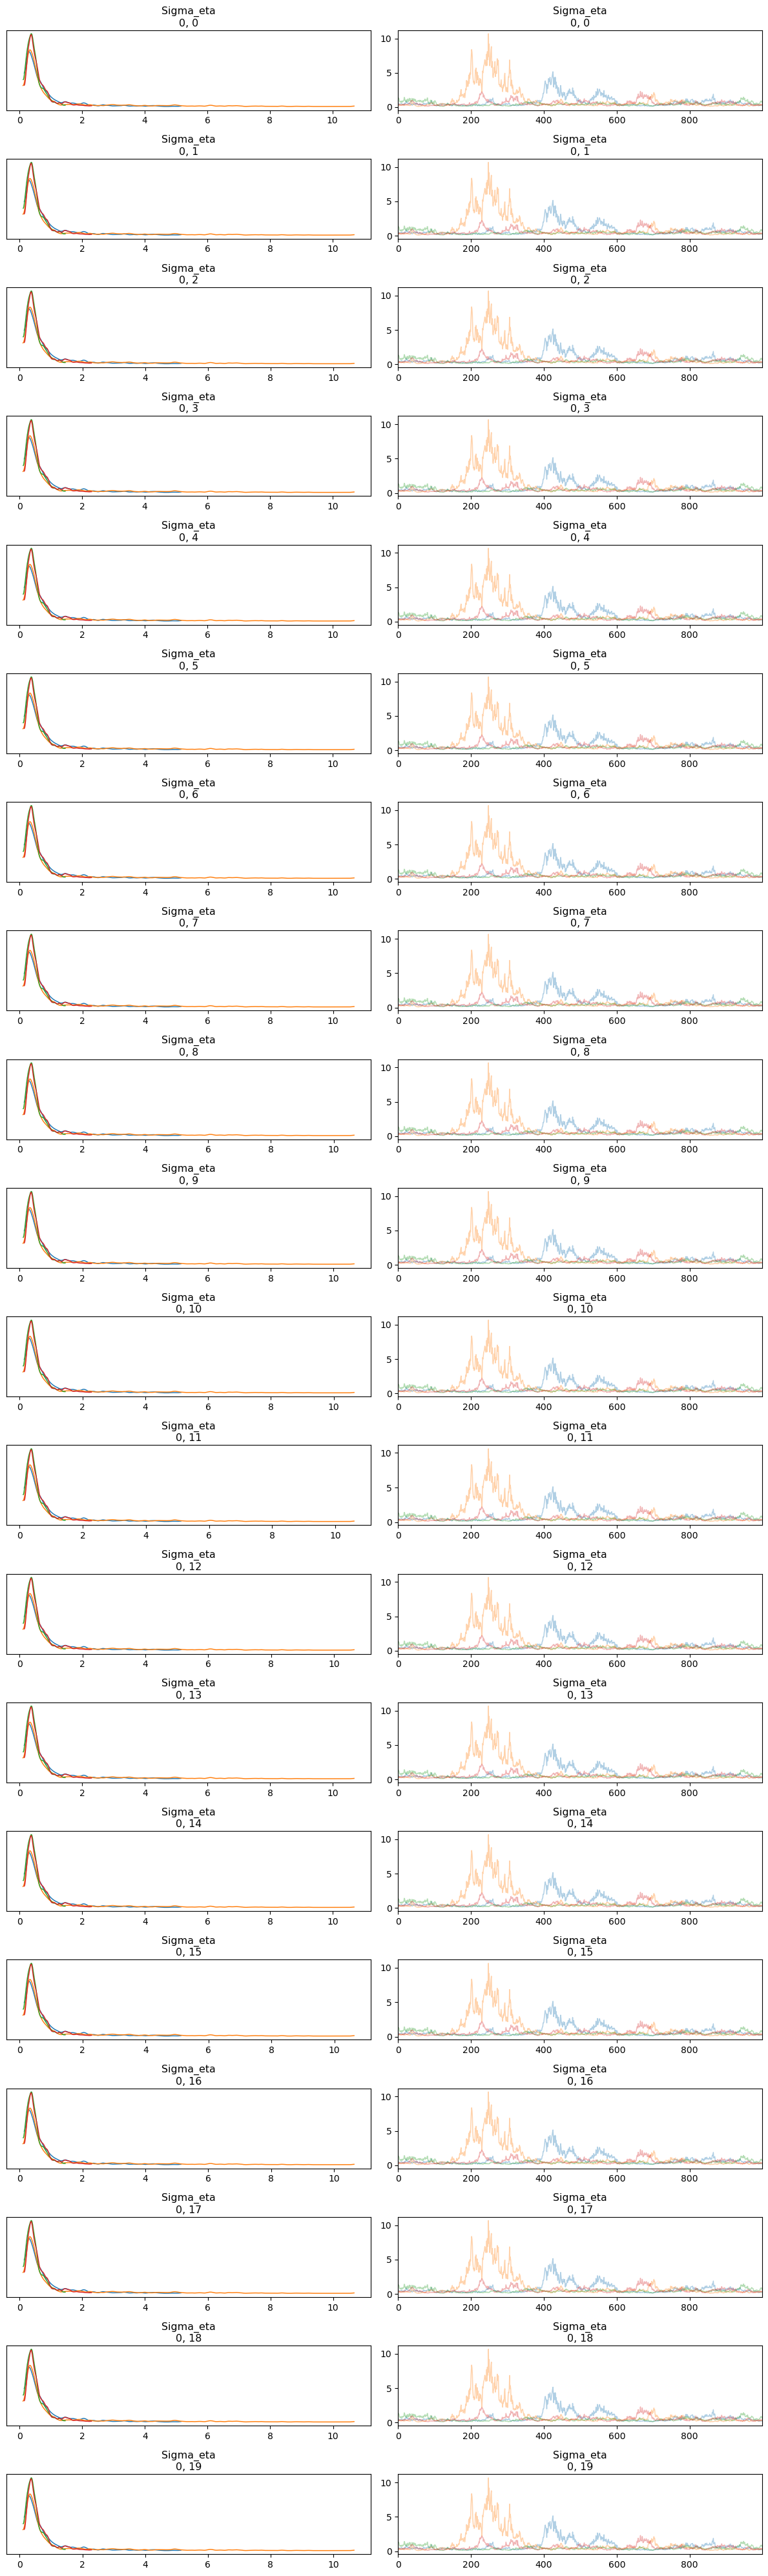

In [111]:
az.plot_trace(spt_lm_eff_data, var_names=[
    "Sigma_eta"], compact=False)
plt.tight_layout()
plt.show()

In [45]:
output_data_summary = spt_lm_fit.summary()

In [114]:
output_data_summary.loc["Sigma_eta[1,1]"]

Mean        0.724720
MCSE        0.160719
StdDev      0.941257
5%          0.195445
50%         0.450774
95%         2.174090
N_Eff      34.298900
N_Eff/s     0.001710
R_hat       1.116270
Name: Sigma_eta[1,1], dtype: float64

In [120]:
new_quantities = spt_lm_eff.generate_quantities(data=spt_lm_data, previous_fit=spt_lm_fit)

18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [2] start processing
18:02:24 - cmdstanpy - INFO - Chain [3] start processing
18:02:24 - cmdstanpy - INFO - Chain [4] start processing


18:03:10 - cmdstanpy - INFO - Chain [3] done processing
18:03:10 - cmdstanpy - INFO - Chain [4] done processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:10 - cmdstanpy - INFO - Chain [2] done processing


RuntimeError: Error during generate_quantities:
Exception: normal_rng: Scale parameter is -0.544022, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490804, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510841, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549661, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629846, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56386, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539377, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.537924, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544893, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.505027, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.432716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.537881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647764, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668518, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641311, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546674, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641887, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.41797, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513534, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519112, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.454175, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.109852, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.270686, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.361292, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.290434, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.463416, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.414496, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.481311, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485752, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.453978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572493, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.561109, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523129, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563642, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.674875, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.55275, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510416, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572254, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510311, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567432, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.54573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.486828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629238, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411727, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.372421, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.425059, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590377, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523339, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610444, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606914, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529364, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656603, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.623973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633823, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651067, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738454, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.701424, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628504, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555299, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.438212, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594026, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.491854, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562672, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.552419, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.488219, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544889, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.47189, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46227, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.408251, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.397142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.375603, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.515762, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.342803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.440512, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.37235, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.396772, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.307693, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.283565, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0614858, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.267825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562956, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.467928, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.54087, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.556982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661238, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761368, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749712, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.74715, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.819599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.821802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758687, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803025, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720835, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714692, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631072, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570653, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618684, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.469953, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.551725, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564876, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.589204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642434, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632304, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608539, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611117, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640016, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649725, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.448622, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.52343, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62949, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629384, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643518, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736504, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743678, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.771781, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720801, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738469, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.805906, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826612, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717626, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64132, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590257, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577615, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539857, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.493908, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509845, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638772, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611304, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704709, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.716276, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731553, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743351, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736607, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741659, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711184, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.687489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.690509, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.82565, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704761, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784304, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.779753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.786498, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.800074, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.812836, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.825781, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822647, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.827449, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.827744, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.789169, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78637, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762496, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739629, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.785252, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.665155, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602706, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.696187, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.721457, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.686373, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.674305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651525, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68668, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787017, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747312, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.664552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740925, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780644, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.797877, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660149, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.557933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759465, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.733533, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739265, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.721244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.694768, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.612298, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.591102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.559205, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603486, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606123, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.581748, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.561887, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.445307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.342031, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.223259, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.336951, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.351003, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.234422, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.32065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.319321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0788685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0861714, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.166517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0251954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.2369, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.176858, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.133775, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.21074, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.275616, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.506028, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.491117, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636323, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619993, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.573773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.50138, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534597, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.522225, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601097, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651264, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.645128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.686318, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75704, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787749, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717572, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692045, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632926, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.654798, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596467, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562924, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564536, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590267, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516288, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.678649, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.463588, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489864, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.535631, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.526789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626901, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531009, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.524681, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.38913, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451778, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.473399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761705, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792862, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.752203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.701833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.678887, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.675647, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637326, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762156, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767377, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724432, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753927, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.721103, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742169, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713548, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77771, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.802963, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793395, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792997, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730584, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77016, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782857, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688736, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689857, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764248, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741798, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742893, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755969, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.745975, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.721396, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718539, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727751, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.697909, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634553, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650737, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590695, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538738, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579384, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.586559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601563, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507133, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.260339, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.3072, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.347462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.414701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.393883, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.330256, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.416527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.355108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.430693, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.297088, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53466, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.434399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344814, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.447471, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444723, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.160018, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.320457, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.257297, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.310114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.431964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.339677, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.453154, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.405437, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.500593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.195407, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.315439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.181746, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0901888, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0382349, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.184244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.263953, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.226061, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00523061, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.297409, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.133663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.170636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0612747, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.100637, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.115269, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0731664, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00653315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.102916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.164006, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.152879, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.359713, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.339881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.121761, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.21164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.142789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.3189, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449899, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.399496, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.35025, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.387083, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.273331, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.162434, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.322414, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.33816, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.314934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.371693, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.390456, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.585947, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.614569, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.583119, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574026, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.429118, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.328596, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.43179, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.33144, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0461032, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0107136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0183352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.212118, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.134127, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0669413, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0661061, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.141091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.140782, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.459977, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534565, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489524, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484838, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555029, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.553663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.586146, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699646, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.697734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.74146, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.779708, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724314, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743903, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.685305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682548, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680196, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703792, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70525, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658474, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.733578, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636975, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620505, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668606, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649629, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.715878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617745, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634805, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671448, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660554, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615571, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604182, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.578798, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601921, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.586489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580218, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661564, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592168, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542354, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677536, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695992, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737443, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.789754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.776403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.828344, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787036, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72613, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.723553, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719135, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822759, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72682, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767804, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.820896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.778476, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747076, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758608, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708013, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.828384, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.819246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.754585, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759801, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.777136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730542, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.836465, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.848719, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826354, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815677, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.811881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807155, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.848053, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84661, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832194, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.829284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.833545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.816916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.854695, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.859016, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.852086, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.847235, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.833127, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822194, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.766666, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.790576, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.776225, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762705, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738947, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768911, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76441, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769085, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702645, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719405, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747584, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.67215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707952, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.69693, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63434, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661837, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.706786, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.666154, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639161, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.664299, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677095, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740516, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683167, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709422, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724551, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.772837, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.79579, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699515, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765115, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651147, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735561, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730369, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71279, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702598, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669757, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661618, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53675, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68581, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.59949, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.561723, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562735, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46626, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512721, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.533669, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.525106, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.277964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.352809, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0755103, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.143346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.235818, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.190859, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.150833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.18604, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.30121, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.389936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0906348, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.380619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.225049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.287239, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484647, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.504848, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.491697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.268172, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.627014, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683002, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659387, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.301239, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.333698, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344179, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.259438, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.11742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.195692, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.352713, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.22575, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.460398, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.391059, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.108148, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.172431, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0206198, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.121399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0313985, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.219361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.186661, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.135234, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.218515, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.211516, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.204107, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.285552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.199554, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.223626, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0374215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.155001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.213497, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.305385, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.267021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.29825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.277423, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.234627, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.22927, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.295527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.280654, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.302907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.48916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.481109, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.374118, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507776, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490481, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.36777, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.401611, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.332433, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0122844, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.045776, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.186998, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.130663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.284323, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.346458, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0376157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.177925, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00428116, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.070707, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.104216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0239984, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0956104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0853286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0449662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0464392, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0994968, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.115402, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0848021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.13878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0130825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.16503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.395877, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.388586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.382682, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.404578, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487691, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.430961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.406415, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.434262, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.359058, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.443126, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.276907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341421, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.247429, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.282509, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344115, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479971, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.361703, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.428483, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.315453, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.392594, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.445813, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.339699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.504342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450956, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489285, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534388, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.216259, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344441, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.335368, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.246439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.172773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.18913, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.329979, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.359247, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.304527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.248056, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.259328, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0114362, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.283919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.21944, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.131515, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.35288, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.240959, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.159002, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.365746, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.222143, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.317476, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.321244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.483043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.475892, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.371622, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.353781, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512915, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.452183, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.336859, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411302, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.339307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.400552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.366495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.28518, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489256, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341642, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.120388, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.118903, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0671064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.324346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.354231, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.369619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.500143, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468024, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484634, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594472, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.52882, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.43151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.396797, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531642, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.59975, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.630871, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.676732, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.547055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.625095, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534029, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570695, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442472, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592533, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.566271, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590113, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509034, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.613222, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.673873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634692, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639788, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.69827, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.67001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683196, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64471, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594765, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.672031, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658219, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.733952, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762521, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787571, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.696596, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764212, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.777641, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
Exception: normal_rng: Scale parameter is -0.701142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677441, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70508, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.664951, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746188, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.748753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640992, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624078, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626366, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742282, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.771431, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72184, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767336, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722687, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712861, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682466, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.67487, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.690086, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650775, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657845, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746069, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758902, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.706357, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782688, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737283, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72243, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498761, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.336517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.418672, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.457972, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.446589, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620899, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667774, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640703, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671451, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761611, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.837223, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.844044, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.865615, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.87934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.880399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.903069, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.889197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.89969, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.850823, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.878873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.846408, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.852219, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782811, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.824253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.811449, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.813951, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773623, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.774382, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.810381, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.820213, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.766081, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.823369, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.830881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682071, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660493, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588822, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598443, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634924, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628967, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659189, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534052, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.557494, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528698, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.394564, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341356, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.302552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.430829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.433117, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485871, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.491465, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.482606, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.505982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749019, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708894, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719219, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.706503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670323, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737328, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734686, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651126, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.505734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.49684, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513588, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.499656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.45413, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531666, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.560411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634981, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.427717, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.599456, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519478, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.499611, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.526764, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.556853, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.536671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.524586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689394, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724577, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.648754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71437, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679109, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728767, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.495456, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.210709, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0957247, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.285878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.128978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.218033, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0128296, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0199298, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.205501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546338, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.392285, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.376733, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.406998, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.326489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.191505, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.297049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.121638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0579195, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0218824, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.140118, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.274588, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.134008, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.183539, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.288787, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.232128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513095, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0423546, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.111305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0422264, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.28628, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.295477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415278, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.272529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.235077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.197881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.379971, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.394037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.192092, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.180507, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.319917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.197386, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.350393, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0371068, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0976716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.214557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.171343, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.371236, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.438753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.375708, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.311153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.354173, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534612, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.326231, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.36119, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.497508, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.416649, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.456671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.440584, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682435, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631856, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.652391, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529295, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468458, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.511706, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611677, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662572, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655013, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618888, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629736, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.625974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.675984, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698228, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565962, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593035, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693764, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.855453, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826959, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768578, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.779336, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725608, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.582936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649902, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730561, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577234, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.55739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570323, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.364467, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57447, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.336749, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.400974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.317922, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.342316, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.089254, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.2404, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.27007, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.256189, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.139194, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.369639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.163867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411426, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.47321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.458741, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570634, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512605, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531832, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.437922, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.482854, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451584, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595469, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608325, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.67477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761385, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7265, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.812774, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636664, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.503289, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597135, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.431116, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496206, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.482875, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539751, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.501991, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571953, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539713, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.556704, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594208, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516651, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507626, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523029, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598857, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608229, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577644, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.745573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653354, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728113, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.716424, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679365, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64205, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577176, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646299, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529818, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.525046, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643182, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.672421, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.684519, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.672028, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650743, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649268, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730568, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.745514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.754234, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695633, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734225, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.560186, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.55764, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646836, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707854, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.700831, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726072, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739812, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.701235, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711723, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.733988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746712, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.794447, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742522, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722251, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.794493, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.776342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.809514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750914, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765291, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650708, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72173, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744242, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.777838, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770433, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806628, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707605, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.654393, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.558638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634343, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659398, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609193, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565209, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.560983, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.445383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466728, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.258709, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.216988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.384724, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.495354, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.410779, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.40852, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.446214, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344792, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.491833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512643, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.216186, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.133566, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.18322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.195246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.205111, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.243771, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.329463, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.291327, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.396848, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.365063, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.440369, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420325, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.521388, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.447617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.364197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450309, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513756, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.403349, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.355804, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569623, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.33949, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.252192, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563515, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46885, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.537135, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609679, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593521, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660252, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689187, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.547985, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543063, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.51067, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.568518, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574171, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617279, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.630552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655983, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616347, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.578272, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577022, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661285, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562832, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610214, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.645108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.654382, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.625383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512366, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.408216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.419671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584154, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.433604, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484141, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588977, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603624, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.376388, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.407601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.387267, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.467346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.454047, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442339, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466623, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.393351, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.436041, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435333, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442373, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.408809, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.577448, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588242, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650575, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641498, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679691, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68199, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517558, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.532872, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498746, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.321207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.548666, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.518549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53958, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550681, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.469437, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480655, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.472387, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.402947, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.38357, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.320558, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.313197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.345524, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616186, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.536237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.61751, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549048, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.465993, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.416037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0517116, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.156155, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.127498, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.161754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.131703, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.325796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.310261, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509015, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442103, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.458829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.483679, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.493501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590255, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571296, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.518981, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.482574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616414, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.582112, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.51869, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.481694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.537909, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.453961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.337372, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.298397, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.253896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.302164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.356358, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.269809, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.441873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451994, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.313883, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.219599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.553971, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.317476, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.275616, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.299726, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.212359, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.179333, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0940317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.111872, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.25772, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.133011, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.151336, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0694725, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0298317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.140973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0527609, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0146749, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.163091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.130052, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.152334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.231916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.172199, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.240585, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.335875, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.358689, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.276547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.226132, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.120381, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.110942, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.318201, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.174899, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.320995, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.137735, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.199317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.299863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.346053, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.314418, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0742543, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.31958, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.406552, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.37468, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.557547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.430732, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529807, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.456656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.524104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.455467, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.481278, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485015, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.482269, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.330949, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.547655, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.55574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.379042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607986, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513595, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.541618, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.478373, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.536254, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601329, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619861, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640107, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615698, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747053, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.766115, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747099, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751535, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631721, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.706403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64779, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653445, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520633, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509195, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.316308, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57959, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670651, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739054, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.666719, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607692, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718406, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.715402, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751415, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.757768, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755886, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756533, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.790695, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.842013, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822185, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.799954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.857902, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.885593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.883139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.846715, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.874633, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.855743, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84248, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84875, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.86796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.854978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.859773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.841381, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.840937, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.813289, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.798466, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.771827, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.810833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.823346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.812903, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756768, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.837794, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.840142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.816286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746679, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765476, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639604, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.710918, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667357, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751929, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724011, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741999, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767759, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.797829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.804799, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806899, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.851537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.825465, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756625, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764516, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660448, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.754885, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66993, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.748702, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72653, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.674147, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.723174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642022, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624704, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598329, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717506, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750943, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759341, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787869, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.715647, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659327, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705813, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750019, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663582, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65465, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610616, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.560122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.497526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.530863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.575934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590302, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642319, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653027, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661308, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714285, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.676803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.694578, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695326, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631183, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641856, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6285, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683535, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702783, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.82022, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727741, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807835, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.716954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767801, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739292, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705185, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.648238, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579068, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708646, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773533, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.827636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.845284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.845978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.771825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759062, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695571, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60871, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617443, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.581262, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622045, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730718, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680872, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667188, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695604, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.800873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755884, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692294, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704774, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688908, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755518, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77417, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720094, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.701153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758133, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739643, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617184, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.700406, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712704, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
Exception: normal_rng: Scale parameter is -0.17137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.228842, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.280567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.136412, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.252906, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.263065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.117855, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.28599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.185663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0912123, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.166142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.107194, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00339932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0431506, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.201964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0642915, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.25878, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.177291, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.161326, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.180367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.000953713, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.132109, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.122507, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.101411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.269128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.185133, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00256558, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0510917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.149037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.134157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.226497, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.196098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.135793, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.141981, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0996101, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0491549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.156389, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.112863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0105866, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00672035, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.239345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0746049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00646416, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.136441, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.103615, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.24268, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.28629, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.268269, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0477356, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.265151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.23458, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0131895, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0464846, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.120527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.037403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.000175768, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.218625, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.222548, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451554, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.505232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.424313, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.36567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.149932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.119639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.386032, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480127, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.439819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.333778, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.202046, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.488461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.277876, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0477266, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.131538, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.239224, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.282293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565149, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.586937, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615514, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726971, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.763177, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77831, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.841489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.841537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.850397, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.854549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.855314, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.867045, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.876032, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.870931, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.866372, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.862219, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.880343, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.887091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.85882, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.864151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.812738, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.804733, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680929, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.605964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597714, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.413605, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.47, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543504, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.534385, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607555, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.590098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643989, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646027, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611447, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633308, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.690922, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762935, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703902, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660585, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639569, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705543, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707991, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71779, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773451, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.823074, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.77286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750034, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749211, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807651, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.808354, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.790826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815147, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.848001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832328, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.851889, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.823709, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.835516, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.857384, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.831392, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832427, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84869, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807737, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.820148, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.777454, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.829217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.82763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.794501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.774187, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.814435, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.829558, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826926, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806107, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806538, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.838001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815581, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.804365, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.791658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.772244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806686, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.799249, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822484, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.798637, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.840235, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.813546, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.806776, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.841204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66871, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65939, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624016, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683481, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7014, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.532204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550156, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496431, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.627499, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.635617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758846, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.776658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703515, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708894, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725054, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.775346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.799305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72953, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770492, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783509, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769725, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.80795, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.822657, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.772703, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.816369, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.729912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770236, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683316, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.759617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713681, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792859, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718268, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.69908, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7603, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803832, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742845, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.778989, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698193, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579683, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.605274, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564543, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595575, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603262, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609741, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.575184, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479431, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489292, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494382, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508206, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529158, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.575708, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.723002, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.748716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.556941, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78629, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.685963, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744957, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75101, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711613, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724787, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76958, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.81439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.82574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.814151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.800649, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.76526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.74882, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.748459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770194, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.813145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.81188, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782057, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.788601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.803015, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.814233, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.842367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.853675, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.825186, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.863237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.833442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.790457, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.846701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832389, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.833333, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770783, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.755638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695391, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72659, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682205, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677719, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705953, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660749, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736294, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714409, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66474, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712067, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.493849, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.502122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677082, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579405, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56291, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527942, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641631, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656944, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.648361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668264, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636568, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587324, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.375451, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.348442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.409245, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.251096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.265883, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.265512, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.370245, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.30104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.248755, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.234458, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.205117, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.316023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.453973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.374645, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.258824, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.310869, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.506912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509144, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.360102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.309668, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.305371, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.225588, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.329858, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.354589, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.481782, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415836, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611152, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.623984, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620288, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.697545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68956, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633572, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695022, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.621135, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718992, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.676383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698915, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734467, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.789447, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689972, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709322, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739875, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.328164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.374344, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411143, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.554907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.483104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510787, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584799, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484748, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.566573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508087, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57527, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576839, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.55287, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610415, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.644167, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531167, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607377, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596591, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63107, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718702, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622758, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.678927, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73471, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707532, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725528, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738097, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758832, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.798037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728395, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705955, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608683, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.696846, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698488, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683507, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.625668, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725414, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680935, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658551, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6394, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576271, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.521548, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528751, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609975, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611013, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.583386, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595365, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.541046, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.558423, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.573124, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555337, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662767, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.635436, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.600651, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.589355, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595457, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.605335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.475834, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.399874, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.343621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.360273, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.287867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.330529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.326344, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.370802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.42832, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.426742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.49217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.585014, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.552459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642824, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.678948, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.554456, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.553652, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512076, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598186, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655948, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662723, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743275, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73802, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717877, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731273, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783025, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.654618, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.672436, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622943, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516372, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.654587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611642, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593328, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529944, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603952, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.614263, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62413, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601191, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.586624, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657032, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.625313, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576882, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610847, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597468, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655543, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628607, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62524, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662554, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699076, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602513, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.471973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.443583, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527551, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451316, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.471701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569741, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.461132, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496598, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.493956, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.492853, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.557375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598209, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.554173, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.575912, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.558318, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563148, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56231, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643665, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744836, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.541637, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.532001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.472046, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.566151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484401, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.501947, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466163, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.319691, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.332762, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.21648, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.461152, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.328565, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.45952, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435584, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.454602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.446162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.2096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341031, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.461537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.43928, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.502463, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.38351, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46088, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.501709, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.356817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.460218, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.503188, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.50507, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.475278, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.578077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57068, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.541577, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628379, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598893, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609916, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610081, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597842, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580952, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572787, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567124, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.414352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.398289, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.522138, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538992, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563095, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.504043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.548065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46509, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.41957, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485013, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.346535, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.385964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.382366, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.434374, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.405489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468633, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.612239, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637235, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662859, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.794822, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712182, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73696, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.691193, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.69265, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.716699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.67439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.61557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71432, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719173, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728071, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736686, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784854, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.778341, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.715968, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.689361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738594, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709337, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709138, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601609, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.630599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.778879, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.823097, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.775092, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.825109, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.863395, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.843236, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.838833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717824, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71076, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727035, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78729, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681566, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713039, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713615, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.735695, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.752309, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.775259, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736392, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661378, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65992, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683729, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.551043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449603, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.469108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.285985, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.446782, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.375078, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528855, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466178, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516227, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.458133, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449176, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579181, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523993, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631171, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634654, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564768, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.720217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751163, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.665595, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64044, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.686395, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667051, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.700237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567512, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730562, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703606, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780429, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.802306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.836462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.772869, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815995, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.774172, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815508, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.844706, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.852476, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.875851, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.867151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.826286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783721, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.775892, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749911, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.644278, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60807, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.652077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656672, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739195, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656612, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70971, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693045, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.686098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.617561, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420228, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.500854, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.506485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.453458, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.428112, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487997, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.515748, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707233, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653765, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698965, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634282, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628484, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.605541, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.51674, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615244, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62835, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.664625, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601058, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523167, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.48935, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494443, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.530955, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.457338, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692908, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.343277, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57644, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.505671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528534, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.697614, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620627, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753595, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764795, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657066, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695631, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.530225, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628566, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619976, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640668, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.620661, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.568828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63199, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619553, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.553145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.500988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474072, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584761, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.43378, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468712, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574681, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544196, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.336345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.293301, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415428, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.44187, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.357588, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442683, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.30961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.406401, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.439239, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.350919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.126098, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.280938, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.363353, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.12116, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.244011, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.132568, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341053, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.352742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.379461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.334371, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.427037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.448713, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.377909, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.429537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.489817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595883, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667954, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542463, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.462639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4674, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598355, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.455399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520014, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.427361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.334658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508223, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.254401, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.235305, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.196891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.324492, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.566595, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604444, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.460494, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.483134, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527297, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480082, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485229, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.465913, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.549653, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.566091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.645047, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65344, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.522254, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631825, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642466, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.690462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78054, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629222, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653868, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658152, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667601, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574532, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544348, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653718, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593628, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.674097, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610855, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638366, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520968, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658866, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.533207, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516036, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.312603, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.445678, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.395367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.406317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.46879, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.502747, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.467255, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634336, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485934, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.327511, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56824, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494787, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542688, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.402606, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592947, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601029, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.523579, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.387079, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.552273, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.540563, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584672, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.552267, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.612055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468179, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.495445, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.615359, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60081, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.599903, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.490543, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695271, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.729686, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.730372, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.578345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.687455, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608759, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609153, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.644314, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.605485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604942, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498332, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507464, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528754, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.559549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.704639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731462, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.694365, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.712406, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.696753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679332, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.721753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607156, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510791, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.472842, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.384422, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496979, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.446785, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.35149, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.410734, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.204593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.238159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.187328, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.281454, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.25536, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.279833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0378376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.253573, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.19885, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.06655, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.125174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.127977, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0464392, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0460123, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.168233, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.164083, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.275658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.230867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.314357, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.242657, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.409975, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.280918, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.334291, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.249655, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.211994, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0492181, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.115222, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.153073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.220358, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.2142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.390037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.513, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.497616, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570772, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.45877, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.574308, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.422439, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415288, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.426374, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.515529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.558215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596976, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.518773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.52688, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.559499, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.413808, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.40612, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.229489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.131884, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.19858, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.111321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.2342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.357876, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
Exception: normal_rng: Scale parameter is -0.610078, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624424, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.648105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651069, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72786, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657004, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7148, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.702838, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681229, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.6488, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71798, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688554, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637792, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634002, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647326, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.535184, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.548473, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.596073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.61047, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640944, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670487, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.61652, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633414, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626385, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562813, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.354618, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480765, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.422758, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.385531, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.111037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0670891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0636529, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.13918, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.004855, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.146855, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.231079, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.216474, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.297817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.378545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.337989, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.407096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.405493, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.431055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.440413, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584778, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466743, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450625, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.612706, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707996, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584722, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517646, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624799, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.65812, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.525486, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636905, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.581728, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662682, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60424, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741201, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744968, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.766893, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.781157, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793464, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.788306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.810982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739475, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726773, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.819957, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.850145, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.832298, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.846553, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.85604, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.836845, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.84726, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.815403, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.821302, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.770579, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.772315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767735, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749164, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773994, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.737995, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.774888, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.779105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.731396, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780381, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.757826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.710803, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.74453, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753851, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.751256, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758435, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649915, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682043, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.741132, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740987, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726687, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756923, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.761769, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768928, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.760124, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.685582, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.652711, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.782065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.804479, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.801503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.794393, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.781315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.797206, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.771778, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753473, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740569, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.717706, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75857, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707133, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.630199, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629038, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.652376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.58037, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.589966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594531, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.653545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726883, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655161, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.635799, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498819, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.456055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66405, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.431726, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.452359, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485538, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474659, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487421, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633784, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608472, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646473, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.665482, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656864, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707823, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641732, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.71881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728767, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.599897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.683658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.672317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695861, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.662636, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.599814, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587193, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.563217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610405, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.59678, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576169, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.614139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.5225, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.575482, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.777617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728895, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795958, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.740511, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637864, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719249, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.636034, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669804, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.657931, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510407, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.334088, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60256, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.652914, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.621143, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517087, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.516959, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519075, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510297, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.51187, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.459042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480297, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.468836, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.259448, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.49108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.279273, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.309848, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.154459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.274814, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.300093, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.41599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.166302, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0486311, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0865797, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.119778, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.294396, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.138321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.231593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.260208, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.276698, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.181057, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.20564, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.348209, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451575, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.324933, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.244541, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.360106, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.404416, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.501685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.53399, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56214, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.744248, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.659072, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.724998, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726598, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.743637, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57914, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661031, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.661435, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651765, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512863, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640537, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.558999, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.587202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571501, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677881, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708283, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544308, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.57675, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.412123, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.210746, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.321336, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.348137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.277371, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.245122, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.217783, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.327813, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.289004, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.20329, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.110966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.233063, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.123521, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.188526, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.248524, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.125396, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.277324, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.159094, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.07586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.141356, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.140317, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0582384, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.103342, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.21036, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.325587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.525016, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510036, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474962, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.379203, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.311943, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.54486, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.410273, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.600753, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.648549, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571115, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546233, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.431977, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.514078, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517936, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.544325, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.592805, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580788, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628567, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.68539, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.660591, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.51908, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.529163, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479329, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.59348, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641782, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.644185, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634147, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.54905, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622872, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.571582, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572547, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.551689, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610347, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.502335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.583436, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.552295, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646732, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.706272, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663392, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.733831, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746725, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.762817, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780999, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.787418, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.739286, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.796619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.830104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807162, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750811, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753712, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705771, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709359, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682557, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650579, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719731, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663997, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699705, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.457227, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.655792, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603223, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.564896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622136, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.531169, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.561017, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608829, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.570788, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608937, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.568841, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579396, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510562, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.600715, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56471, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.584699, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555477, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631895, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.560327, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4775, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.559684, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442788, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593251, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.37281, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.312103, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.227683, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.175449, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.112643, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.068356, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.283294, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.168682, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.335597, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420231, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.166253, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.112281, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.00791091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0210315, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.103927, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.191525, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0934003, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.356771, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.410159, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.397265, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.390081, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.381001, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.400924, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.495466, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474026, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.411056, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.364858, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543088, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629528, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588606, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631221, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.642489, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.580232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.554411, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.581897, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631712, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641843, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73841, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72663, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750359, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72841, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.691104, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.69078, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.637426, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.602513, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.607833, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.551389, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569294, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.628935, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.611812, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.619449, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507542, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.521084, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.56736, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.501789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.496363, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.49333, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.632987, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.512761, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508413, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.463238, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520347, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.455889, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.533506, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.466595, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.442587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.339994, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.130429, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0357534, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.256873, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0864214, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0174202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.085387, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.219295, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.419983, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.402887, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.424541, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.334437, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.265442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.197123, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.259175, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.084593, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.229738, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.187769, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0598473, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0338559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.02673, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.125747, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.114463, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.169812, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.297758, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.299961, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.160602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.079495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.123812, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344033, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.261212, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.559586, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.510891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.521381, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.504621, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.35495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435977, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.455408, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344406, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.261599, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.359181, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.252443, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.364572, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.419288, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.4086, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.291232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.362284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.216345, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.292807, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.204018, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508815, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.493545, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616826, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606438, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.561767, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.543205, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449757, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.407065, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.465064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.467648, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.520358, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.486108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606292, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.597574, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681126, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.675496, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711779, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.726356, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.734303, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.738383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722023, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.699024, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.709197, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713063, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.829822, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.847031, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.797124, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.811057, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.783156, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.773662, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.792263, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.798139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746105, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.719616, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.839299, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.608539, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725678, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.688795, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.714808, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693639, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.673335, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.722739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.62917, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.474433, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.647236, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565064, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.665293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.622154, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643487, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.758867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.695617, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.693502, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.705932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718727, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.78269, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.842163, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.793704, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.753414, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.710981, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.7473, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.747546, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.72641, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.649626, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.681042, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.678789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663299, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.66558, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565196, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480779, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.562794, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.514151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.52886, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.434521, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.436671, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.499926, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415134, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.101307, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.335562, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.23294, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.319423, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.228872, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0951284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.274152, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0811669, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.387139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.119321, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.191087, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.150127, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.351011, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.542263, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451112, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.255177, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.440138, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.475179, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.517247, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.220964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.248744, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.423849, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.416652, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.30731, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.328155, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0653393, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.116283, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.381764, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.293834, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.242204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.408513, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498014, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.377383, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.506096, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567429, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.591378, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682781, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633597, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651277, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.609546, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.432115, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.384905, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.439703, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.576083, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.536727, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610763, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633287, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.535938, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663126, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.684405, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638408, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.598974, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.613125, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579745, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.593277, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.565245, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718048, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.711906, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.472237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.567246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487395, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626994, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663806, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.680463, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651058, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.610258, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60689, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.623246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.63423, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.646114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.498694, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569795, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616801, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.639891, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.418715, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.451091, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.432809, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.428128, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.50003, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546658, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.569256, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.601142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.600214, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.537517, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.546602, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.521582, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603066, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603807, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.626232, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.508102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.503242, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435698, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.42427, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.585504, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444828, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.463215, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.404472, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484176, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.439484, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.343685, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.315752, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.44737, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.311493, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.214459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.208495, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.509919, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450956, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.539009, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420657, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.47982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.450598, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.658528, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.616742, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603998, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.670325, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624309, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.696049, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.527769, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671579, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73298, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713576, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.676789, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.669796, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682137, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.715587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.756015, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.638511, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.671629, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528809, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.594142, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.588228, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.555021, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.624199, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.459056, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.629811, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.668918, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.623482, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.460114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494886, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.554102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.319673, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.257032, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.268167, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.031848, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.323749, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.458168, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.433386, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.212935, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.479334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.427132, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.528117, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.540914, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550714, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.550139, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.485665, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.535788, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.540815, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.618209, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.634846, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.591941, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.795535, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.732429, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.769012, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784111, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.807624, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.796628, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.79728, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.818479, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.768121, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.804701, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.816932, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.764587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.745363, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.631714, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.60844, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579945, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.673926, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.641896, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656503, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.515575, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.579146, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.494861, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.538583, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.533361, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.415421, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.572438, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.373688, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.390585, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.383233, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.387375, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.350044, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519108, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.44174, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.278972, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.325442, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.39548, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.42428, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.30101, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.487334, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.301478, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.519964, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.155151, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.231551, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.213015, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.236237, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.358168, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.401525, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.244672, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.150069, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.257566, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.547218, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.408171, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.094171, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.142767, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.168716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.258879, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.166295, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.209376, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.202459, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0904531, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0900731, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.368451, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.435202, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.463625, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.524591, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449406, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.449055, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.341374, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.291102, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.311966, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.358673, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.0958716, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.131485, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.23069, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.465027, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.291823, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.270904, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.168385, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.207656, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.298417, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.480867, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.434568, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.551346, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.11619, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.381791, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.486726, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.369865, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.350216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.351587, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.355058, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.239293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.547239, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.604973, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.507559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.606461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.621005, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.700004, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.725775, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.748311, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.692073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.708746, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.723367, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.752491, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.784025, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.79461, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.698165, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.703121, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.70073, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.728696, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.778491, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.785268, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.749077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.650929, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.675559, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.742278, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.746051, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.682352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.679179, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.633379, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.47352, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.48904, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.477808, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.420978, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.433293, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.344638, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.433204, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.41252, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.444951, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.484467, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.471222, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.456509, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.467739, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.684697, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.656982, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.767521, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.727284, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.765027, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.813923, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.780216, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.801306, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.779714, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.816949, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.716009, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.750907, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.776071, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.75899, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.677071, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.73264, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.667242, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.707113, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.663946, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.694217, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.591735, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.635114, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.713004, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.736988, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.718511, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.643246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.651077, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.603177, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.621246, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.64864, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.640446, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
	Exception: normal_rng: Scale parameter is -0.595752, but must be positive finite! (in 'C:/Users/nb23N/Downloads/stan/spt_lm.stan', line 217, column 10 to column 62)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\nb23N\\Downloads\\stan\\spt_lm.exe', 'id=1', 'random', 'seed=68579', 'data', 'file=C:\\Users\\nb23N\\AppData\\Local\\Temp\\tmpt0lkwbq1\\2xgenvi2.json', 'output', 'file=C:\\Users\\nb23N\\AppData\\Local\\Temp\\tmpt0lkwbq1\\spt_lm54ugqpa8\\spt_lm-20240205180224_1.csv', 'method=generate_quantities', 'fitted_params=C:\\Users\\nb23N\\AppData\\Local\\Temp\\tmpt0lkwbq1\\spt_lm45z2dezz\\spt_lm-20240205114718_1.csv']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\nb23N\AppData\Local\Temp\tmpt0lkwbq1\spt_lm54ugqpa8\spt_lm-20240205180224_1.csv
 console_msgs (if any):
	C:\Users\nb23N\AppData\Local\Temp\tmpt0lkwbq1\spt_lm54ugqpa8\spt_lm-20240205180224_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

# XI. Saving Things

In [47]:
import pickle
import pandas as pd
from datetime import datetime

# Generate a unique timestamp
unique_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the Stan model code
stan_model_code = spt_lm
stan_file_name = f"stan_model_{unique_timestamp}.stan"
with open(stan_file_name, "w") as file:
    file.write(stan_model_code)

# Save the Stan fit object
stan_fit = spt_lm_fit
fit_file_name = f"stan_fit_{unique_timestamp}.pkl"
with open(fit_file_name, "wb") as file:
    pickle.dump(stan_fit, file)

# Save the trace plot
#trace_plot = az.plot_trace(spt_lm_eff_data, var_names=["Sigma_eta"], compact=False)  # replace with your actual plot object
#plot_file_name = f"trace_plot_{unique_timestamp}.png"
#trace_plot.figure.savefig(plot_file_name)
#plt.close(trace_plot.figure)

# Save the summary of the fit object
summary_df = pd.DataFrame(spt_lm_fit.summary())
summary_file_name = f"stan_summary_{unique_timestamp}.csv"
summary_df.to_csv(summary_file_name)
